# Post processing plots

In [276]:
import lightkurve as lk
import astropy.table as astab
import pandas as pd
import numpy as np
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import FormatStrFormatter

from tqdm import tqdm
# %pylab inline
# pylab.rcParams['figure.figsize'] = (16, 8)
import warnings
import astropy.table as astab
from astropy.io import fits

from adjustText import adjust_text

warnings.filterwarnings('ignore',
    message="WARNING (theano.tensor.opt): Cannot construct a scalar test value from a test value with no size:"
)
print(astropy.__version__)

import pickle as pk
import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import exoplanet as xo

import arviz as az
from corner import corner

from scipy.signal import savgol_filter
import wquantiles

# %matplotlib widget
dd = "/Users/kjaehnig/CCA_work/GAT/"

def docs_setup():
    """Set some environment variables and ignore some warnings for the docs"""
    import logging
    import warnings


    # Remove when Theano is updated
    warnings.filterwarnings("ignore", category=DeprecationWarning)
    warnings.filterwarnings("ignore", category=FutureWarning)

    # Remove when arviz is updated
    warnings.filterwarnings("ignore", category=UserWarning)

    logger = logging.getLogger("theano.gof.compilelock")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("theano.tensor.opt")
    logger.setLevel(logging.ERROR)
    logger = logging.getLogger("exoplanet")
    logger.setLevel(logging.DEBUG)

docs_setup()

import helper_functions as hf

from matplotlib import rcParams
rcParams['font.size'] = 22
rcParams['font.weight'] = 'heavy'
rcParams['axes.labelweight'] = rcParams['font.weight']
rcParams['axes.labelsize'] = rcParams['font.size']
# rcParams['

4.3.1


In [3]:
def plot_residuals_of_models(TIC_TARGET=None,Ntune=1000, Ndraw=500, chains=4,
                                model_list=('diagonal','isotropized_isochrones','isochrones', 'diagonalized_isochrones')):

    fig,axes = plt.subplots(nrows=2,ncols=1,figsize=(16,8))    
    
    for ii,model_type in enumerate(model_list):
        file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
        indres = pk.load(file)
        file.close()
#         print(model_type)
#         pymc3dict = load_all_data_for_pymc3_model(TIC_TARGET,sparse_factor=5)
#         print(indres.keys())
        x,y = indres['lcdat']['x'],indres['lcdat']['y']
        x_rv, y_rv = indres['rvdat']['x_rv'],indres['rvdat']['y_rv']
              
        lcact = indres['lcact']
        rvact = indres['rvact']
        
#         with model:
#             gp_pred = (
#                 pmx.eval_in_model(extras['gp_lc_pred'], indres['map_soln'])
#                       )
            
        flat_samps = indres['trace'].posterior.stack(sample=("chain","draw"))
        p_med = np.median(flat_samps['period'])
        t0_med = np.median(flat_samps['t0'])
        
        xfold = hf.fold(x, p_med, t0_med)
        inds = np.argsort(xfold)
#         print(len(indres['mask']),len(y))
        y_min_gp_pred = y - indres['gp_pred']
        axes[0].plot(xfold[inds], y_min_gp_pred[inds] - np.median(lcact,axis=0)[indres['mask']][inds], c=f"C{ii*3}",zorder=ii,lw=0.5, label=model_type)


        y1,y2 = axes[0].set_ylim()
        maxY = max(abs(y1),abs(y2))
#         axes[0].set_ylim(-maxY, maxY)
        axes[0].axhline(0.0, ls='--', c='gray')

        xfold = hf.fold(x_rv, p_med, t0_med)
        inds = np.argsort(xfold)
        axes[1].plot(xfold[inds], y_rv[inds] - np.median(rvact,axis=0)[inds], c=f"C{ii*3}",zorder=ii,lw=3, label=model_type)
        y1,y2 = axes[1].set_ylim()
        maxY = max(abs(y1),abs(y2))
#         axes[1].set_ylim(-maxY, maxY)
        axes[1].axhline(0.0, ls='--', c='gray')
        

#         y_min_gp_pred = phased_res['lcDAT'][1] - phased_res['gp_pred']
#         xfold = fold(phased_res['lcDAT'][0], phased_res["POSTmed"]['p_med'], phased_res['POSTmed']['t0_med'])
#         inds = np.argsort(xfold)
#         axes[0].plot(xfold[inds], y_min_gp_pred[inds] - np.percentile(phased_res['lcact'],50,axis=0)[inds],c='red',lw=0.5, label='individual priors')

#         xfold = fold(phased_res['rvDAT'][0], phased_res['POSTmed']['p_med'], phased_res['POSTmed']['t0_med'])
#         inds = np.argsort(xfold)
#         axes[1].plot(xfold[inds], phased_res['rvDAT'][1][inds] - np.percentile(phased_res['rvact'],50,axis=0)[inds], c='red',lw=1)

        axes[0].set_ylim(min(y), max(y))
        axes[1].set_ylim(min(y_rv), max(y_rv))
        
        axes[0].set_ylabel("flux residuals [ppt]", fontsize=12)
        axes[1].set_ylabel("RV residuals [kms]", fontsize=12)
        axes[1].set_xlabel("phase [days]")
        axes[0].set_title(TIC_TARGET)
        axes[1].legend(fontsize=10, loc='best')

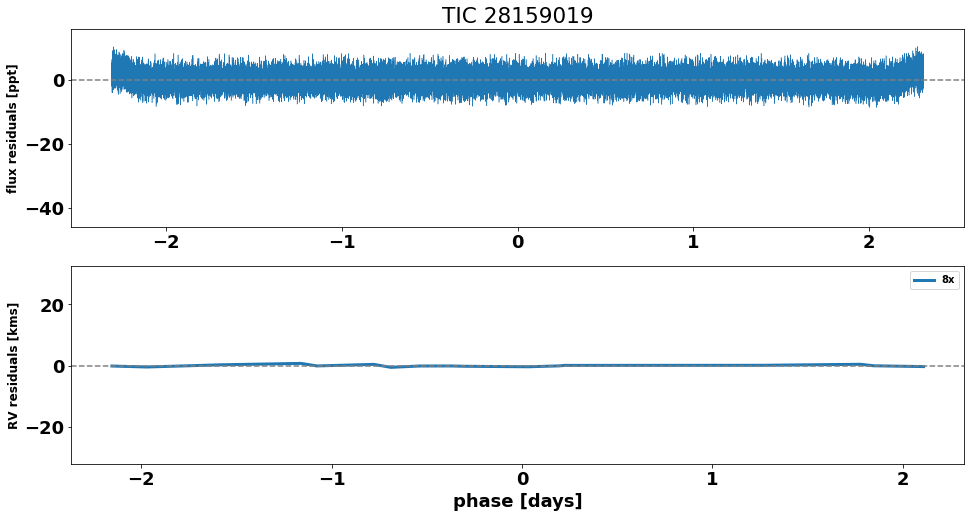

In [4]:
# from helper_functions import *
plot_target = 'TIC 28159019'
plot_residuals_of_models(plot_target,chains=6, model_list=['8x'],Ntune=1500, Ndraw=750)

In [5]:
def plot_all_model_corners(TIC_TARGET, Ntune=1000, Ndraw=500, chains=4,
                                model_list=['diagonal','isotropized_isochrones','isochrones', 'diagonalized_isochrones']):
    
    for ii, model_type in enumerate(model_list):
    
#     file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_IND.pickle",'rb')
#     ind_res_dict = pk.load(file)
#     file.close()
        try:
            xslabels = [r'$log{\rho}$', r'$logM_{1}$', r'$logR_{1}$', r'$logQ$', r'$logS$', r'$logK$','b',r'$t_{0}$', r'$t_{n}$']
            file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
            mv_res_dict = pk.load(file)
            file.close()

            MVtrace = mv_res_dict['trace']
            MVtrace.posterior['log_rho'] = np.log( MVtrace.posterior['M1'] / ( (4./3.) * np.pi * MVtrace.posterior['R1']**3.) )

            MVmapsoln = mv_res_dict['map_soln']
            MVmapsoln['log_rho'] = np.log( MVmapsoln['M1'] / ( (4./3.) * np.pi * MVmapsoln['R1']**3.) )
    #         INDtrace = ind_res_dict['trace']
            print(ii)
            if ii == 0:
                fig = corner(MVtrace, var_names=['log_rho','log_M1','log_R1','log_q','log_s','log_k','b','t0','tn'], smooth=1, use_math_text=True,
                  truths=MVmapsoln, labels=xslabels, labelpad=0.1, label_kwargs={'fontsize':16}, 
                   range=[1,1,1,1,1,1,1,1,1], color=f'C{ii*3}',label=model_type,
                        truth_color=f'C{ii*3}')

            if ii > 0:
                corner(MVtrace, var_names=['log_rho','log_M1','log_R1','log_q','log_s','log_k','b','t0','tn'], 
                   smooth=1, use_math_text=True, fig=fig, color=f'C{ii*3}',range=[1,1,1,1,1,1,1,1,1,], label=model_type,
                      labels=xslabels, labelpad=0.1, truths=MVmapsoln,truth_color=f'C{ii*3}')
                             
            fig.text(0.50,(75-ii*2.)/100.,model_type, color=f'C{ii*3}',fontsize=30)
        except:
            continue

# #     fig.text(0.50,0.74,'isotropized isochrones', color='C3', size=16)
# #     fig.text(0.5,0.73, 'isochrones', color='C6', size=16)
# #     fig.text(0.5,0.72, 'diagonalized isochrones', color='C9', size=16)
# #     fig.axes[0].set_title()
# flat_samps = trace.posterior.stack(sample=("chain", "draw"))
# # for data_var in flat_samps.data_vars.keys():
# #     print(data_var)
# plt.figure()



# # Get the posterior median orbital parameters
# p = np.median(flat_samps["period"])
# t0 = np.median(flat_samps["t0"])
# lcpred = np.percentile(flat_samps['lc_pred'], 50,axis=0)
# mod_phase = np.linspace(-.3, 0.3, len(lcpred))

# # Plot the folded data
# x_fold = (x[mask] - t0 + 0.5 * p) % p - 0.5 * p
# m = np.abs(x_fold) < 0.3
# plt.plot(
#     x_fold[m], y[mask][m] - np.std(lcpred), ".k", label="data", zorder=-1000
# )



# plt.plot(mod_phase, lcpred)

0


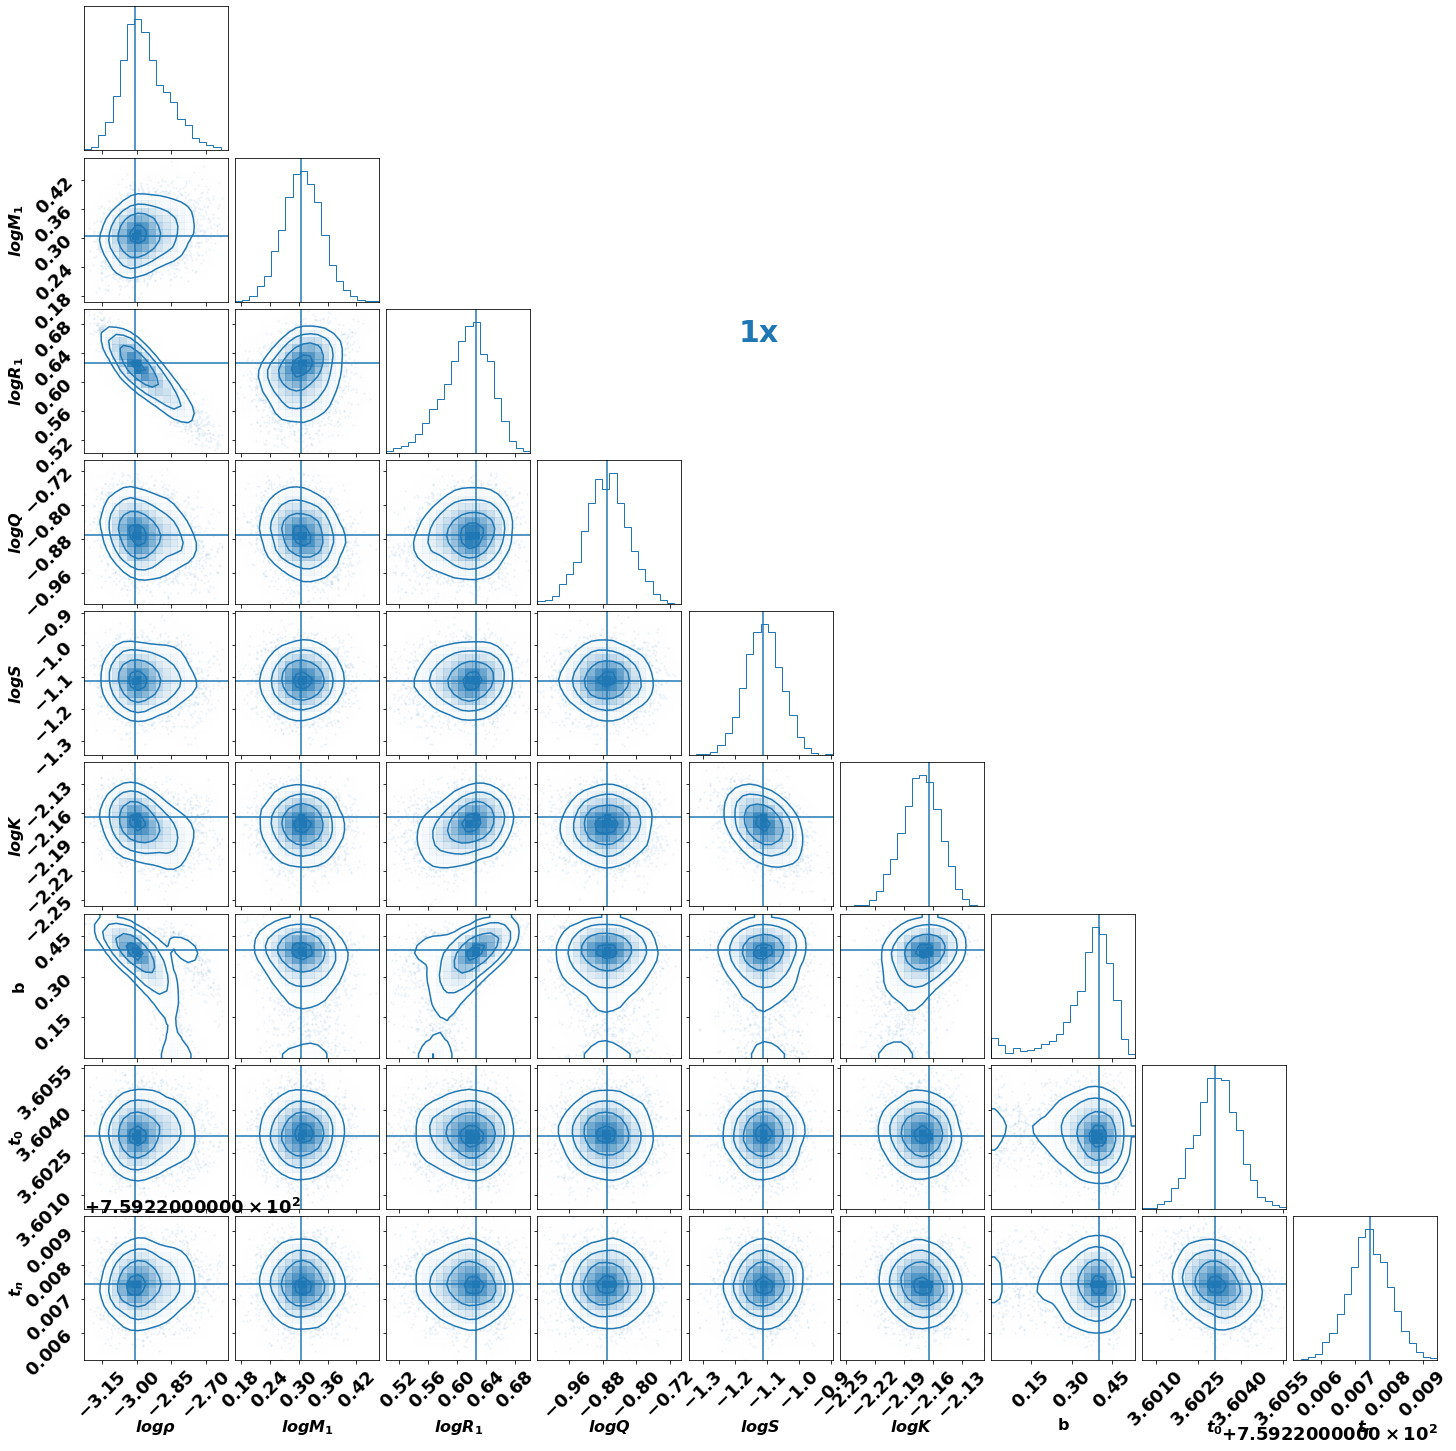

In [6]:
from helper_functions import *
plot_target = 'TIC 164458426'
plot_all_model_corners(plot_target, chains=8, Ntune=1000, Ndraw=500, model_list=['1x'])
plot_dest = f'/Users/kjaehnig/CCA_work/GAT/apotess_systems/{plot_target.replace(" ","_")}_files/figures/'
# plt.savefig(plot_dest+f"{plot_target}_four_MV_model_corner_plot.png", dpi=150, bbox_inches='tight')
plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/apotess_systems/{plot_target.replace(' ','_')}_files/{plot_target.replace(' ','_')}_multi_model_post_corner.png",
            bbo_inches='tight', dpi=150)

In [7]:
def plot_LC_RV_phased_curves(TIC_TARGET, Ntune=1000, Ndraw=500, chains=4,
                                model_list=['diagonal','isotropized_isochrones','isochrones', 'diagonalized_isochrones'],
                            save_to_disk=False):
    
    
    fig, axes = plt.subplots(figsize=(10,10), ncols=1, nrows=2)

    for ii, model_type in enumerate(model_list):
        try:
            modcol = f"C{int((ii*3)+1)}"

            file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
            mv_res_dict = pk.load(file)
            file.close()

            flat_samps = mv_res_dict['trace'].posterior.stack(sample=('chain','draw'))
            x_rv = mv_res_dict['rvdat']['x_rv']
            y_rv = mv_res_dict['rvdat']['y_rv']
            yerr_rv = mv_res_dict['rvdat']['yerr_rv']

            x = mv_res_dict['lcdat']['x']
            y = mv_res_dict['lcdat']['y']
            yerr = mv_res_dict['lcdat']['yerr']

            gp_pred = mv_res_dict['gp_pred']

            trv = mv_res_dict['trv']
            tlc = mv_res_dict['tlc'] 

            rvvals = mv_res_dict['rvvals']
            lcvals = mv_res_dict['lcvals']

            p_med = flat_samps['period'].median().values
            t0_med = flat_samps['t0'].median().values
            mean_rv = flat_samps['mean_rv'].median().values
            mean_lc = flat_samps['mean_lc'].median().values
            # gp_pred = flat_samps['gp_pred'].median().values

            # print(flat_samps['ecc'].median())
            if ii == 0:
                axes[0].errorbar(hf.fold(x_rv, p_med, t0_med),
                          y_rv, yerr=yerr_rv, fmt=".k")
            # rvvals = indres['rvvals']
            # lcvals = indres['lcvals']

            t_fold = hf.fold(trv, p_med, t0_med)
            inds = np.argsort(t_fold)
            pred = np.percentile(rvvals, [16, 50, 84], axis=0)
            axes[0].plot(t_fold[inds], pred[1][inds], color=modcol, zorder=2)

            pred = np.percentile(rvvals, [16, 84], axis=0)
            art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.5, zorder=1)
            art.set_edgecolor("none")

            pred = np.percentile(rvvals, [5, 95], axis=0)
            art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.25, zorder=0)
            art.set_edgecolor("none")

            # pred = np.percentile(rvvals, [1, 99], axis=0)
            # art = axes[0].fill_between(t_fold, pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
            # art.set_edgecolor("none")
            # axes[0].set_ylim(-40, 40)
            # axes[1].set_ylim(-40, 40)
            axes[0].set_ylabel("RV [kms]")

    #         x,y = extras['x'],extras['y']
            # with model:
            #     gp_pred = (
            #         pmx.eval_in_model(extras["gp_lc_pred"], post_map_soln)
            #     )

            if ii == 0:
                axes[1].errorbar(hf.fold(x, p_med, t0_med),
                          y-gp_pred, fmt=".k", ms=1, zorder=-1)

            t_fold = hf.fold(tlc, p_med, t0_med)
            inds = np.argsort(t_fold)
            pred = np.percentile(lcvals, [16, 50, 84], axis=0)
            axes[1].plot(t_fold[inds], pred[1][inds], color=modcol, zorder=2,label=model_type)

            pred = np.percentile(lcvals, [16, 84], axis=0)
            art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.5, zorder=1)
            art.set_edgecolor("none")

            pred = np.percentile(lcvals, [5, 95], axis=0)
            art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.25, zorder=0)
            art.set_edgecolor("none")

            # pred = np.percentile(flat_samps['lc_pred'][inds], [1, 99], axis=-1)
            # art = axes[1].fill_between(t_fold[inds], pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
            # art.set_edgecolor("none")
            axes[1].legend()
            axes[1].set_xlabel("phase [days]")
            axes[1].set_ylabel("flux [ppt]")
            axes[0].set_title(TIC_TARGET)
        except:
            continue
    if save_to_disk:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/apotess_systems/{TIC_TARGET.replace(' ','_')}_files/multi_model_RV_LC_curves.png", bbox_inches='tight', dpi=150)
    return (fig, axes)

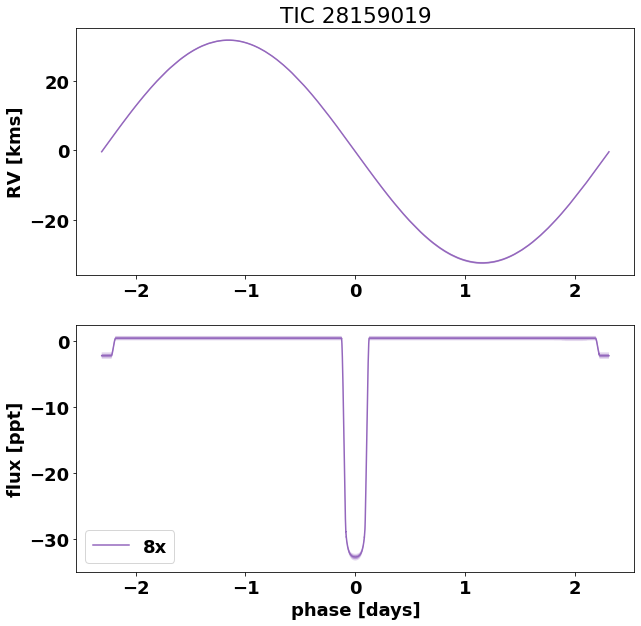

In [8]:
plot_target = 'TIC 28159019'
fig,axes = plot_LC_RV_phased_curves(plot_target, chains=6, Ntune=1500, Ndraw=750, model_list=['1x','8x'], save_to_disk=True)
# axes[1].set_xlim(1.4,1.6)

In [291]:
def plot_LC_RV_phased_curve_gallery(TIC_TARGETs=['TIC 20215452'], Ntune=1000, Ndraw=500, chains=4,
                                model_list=['1x'], save_to_disk=False, Ncols=4, file_args=None):
    
    if file_args is None:
        file_args = ''
    else:
        file_args = f"_{file_args}"
    
    nrows = 2 if len(TIC_TARGETs)/float(Ncols) <= 1.0 else 4
    fig, all_axes = plt.subplots(figsize=(20,10), ncols=min(Ncols, len(TIC_TARGETs)), nrows=nrows)

    for jj, ticid in enumerate(TIC_TARGETs):
        if len(TIC_TARGETs)==1:
            axes = all_axes
        else:
            if jj <= Ncols-1:
                axes = all_axes[:2,jj]
            if jj > Ncols-1:
                axes = all_axes[2:,jj-Ncols]
        #         print(axes)
        axes[0].set_title(f"{ticid}, ({jj})")

        for ii, model_type in enumerate(model_list):
            modcol = f"C{int((ii*3)+1)}"
            try:

                file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{ticid}{file_args}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
                mv_res_dict = pk.load(file)
                file.close()

                flat_samps = mv_res_dict['trace'].posterior.stack(sample=('chain','draw'))
                x_rv = mv_res_dict['rvdat']['x_rv']
                y_rv = mv_res_dict['rvdat']['y_rv']
                yerr_rv = mv_res_dict['rvdat']['yerr_rv']

                x = mv_res_dict['lcdat']['x']
                y = mv_res_dict['lcdat']['y']
                yerr = mv_res_dict['lcdat']['yerr']

                gp_pred = mv_res_dict['gp_pred']

                trv = mv_res_dict['trv']
                tlc = mv_res_dict['tlc'] 

                rvvals = mv_res_dict['rvvals']
                lcvals = mv_res_dict['lcvals']

                p_med = flat_samps['period'].median().values
                t0_med = flat_samps['t0'].median().values
                mean_rv = flat_samps['mean_rv'].median().values
                mean_lc = flat_samps['mean_lc'].median().values
                # gp_pred = flat_samps['gp_pred'].median().values

                # print(flat_samps['ecc'].median())

                axes[0].errorbar(hf.fold(x_rv, p_med, t0_med),
                              y_rv, yerr=yerr_rv, fmt=".k")
                # rvvals = indres['rvvals']
                # lcvals = indres['lcvals']

                t_fold = hf.fold(trv, p_med, t0_med)
                inds = np.argsort(t_fold)
                pred = np.percentile(rvvals, [16, 50, 84], axis=0)
                axes[0].plot(t_fold[inds], pred[1][inds], color=modcol, zorder=2)

                pred = np.percentile(rvvals, [16, 84], axis=0)
                art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.5, zorder=1)
                art.set_edgecolor("none")

                pred = np.percentile(rvvals, [5, 95], axis=0)
                art = axes[0].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.25, zorder=0)
                art.set_edgecolor("none")

                # pred = np.percentile(rvvals, [1, 99], axis=0)
                # art = axes[0].fill_between(t_fold, pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
                # art.set_edgecolor("none")
                # axes[0].set_ylim(-40, 40)
                # axes[1].set_ylim(-40, 40)
                axes[0].set_ylabel("RV [kms]")

        #         x,y = extras['x'],extras['y']
                # with model:
                #     gp_pred = (
                #         pmx.eval_in_model(extras["gp_lc_pred"], post_map_soln)
                #     )


                axes[1].errorbar(hf.fold(x, p_med, t0_med),
                              y-gp_pred, fmt=".k", ms=1, zorder=-1)

                t_fold = hf.fold(tlc, p_med, t0_med)
                inds = np.argsort(t_fold)
                pred = np.percentile(lcvals, [16, 50, 84], axis=0)
                axes[1].plot(t_fold[inds], pred[1][inds], color=modcol, zorder=2,label=model_type)

                pred = np.percentile(lcvals, [16, 84], axis=0)
                art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.5, zorder=1)
                art.set_edgecolor("none")

                pred = np.percentile(lcvals, [5, 95], axis=0)
                art = axes[1].fill_between(t_fold[inds], pred[0][inds], pred[1][inds], color=modcol, alpha=0.25, zorder=0)
                art.set_edgecolor("none")

                # pred = np.percentile(flat_samps['lc_pred'][inds], [1, 99], axis=-1)
                # art = axes[1].fill_between(t_fold[inds], pred[0], pred[1], color='C1', alpha=0.10, zorder=0)
                # art.set_edgecolor("none")
                axes[1].legend(fontsize=12)
                axes[1].set_xlabel("phase [days]")
                axes[1].set_ylabel("flux [ppt]")
            except:
                continue
    [lil_ax.set_ylabel('') for lil_ax in all_axes[0][1:]]
    [lil_ax.set_ylabel('') for lil_ax in all_axes[1][1:]]

    [lil_ax.tick_params(direction='in',labelbottom=False) for lil_ax in all_axes[0][:]]
    [lil_ax.tick_params(direction='in',) for lil_ax in all_axes[1][:]]
    if save_to_disk:
        fig.subplots_adjust(hspace=0.0)
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/{'_'.join(TIC_TARGETs).replace(' ','_')}_LC_curves.png", bbox_inches='tight', dpi=150)
    return (fig,all_axes)
    
tic_systems_of_interest = [
    28159019,
    272074664,
    20215452,
    99254945,
    144441148,
    169820068,
    126232983,
    164458426,
    164527723,
    165453878,
    258108067,
    271548206,
    365204192
    ]

(<Figure size 1440x720 with 12 Axes>,
 array([[<AxesSubplot:title={'center':'TIC 28159019, (0)'}, ylabel='RV [kms]'>,
         <AxesSubplot:title={'center':'TIC 272074664, (1)'}>,
         <AxesSubplot:title={'center':'TIC 20215452, (2)'}>,
         <AxesSubplot:title={'center':'TIC 99254945, (3)'}>,
         <AxesSubplot:title={'center':'TIC 144441148, (4)'}>,
         <AxesSubplot:title={'center':'TIC 169820068, (5)'}>],
        [<AxesSubplot:>, <AxesSubplot:>,
         <AxesSubplot:xlabel='phase [days]'>,
         <AxesSubplot:xlabel='phase [days]'>, <AxesSubplot:>,
         <AxesSubplot:xlabel='phase [days]'>]], dtype=object))

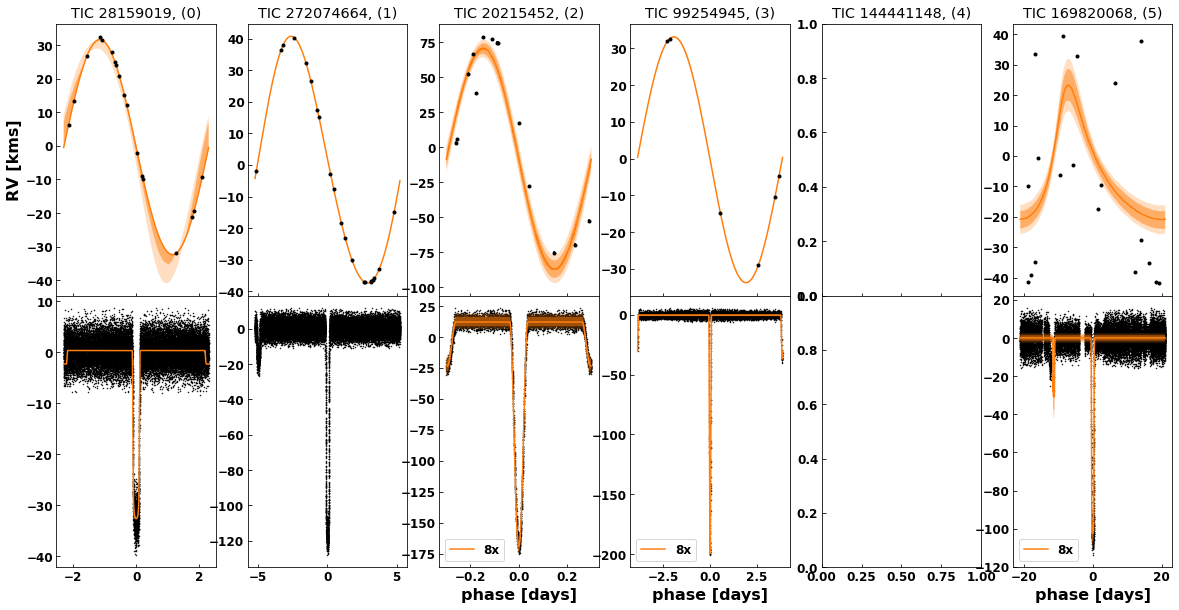

In [292]:
plot_targets = [f'TIC {id}' for id in tic_systems_of_interest[:6]]
# plot_targets = [f'TIC {id}' for id in ['20215452','164458426','165453878','258108067','271548206']]
plot_LC_RV_phased_curve_gallery(plot_targets, chains=8, Ntune=1000, Ndraw=500, model_list=['8x'],save_to_disk=True, Ncols=6, file_args='sf2')

(<Figure size 1440x1080 with 14 Axes>,
 array([[<AxesSubplot:title={'center':'TIC 126232983, (0)'}, ylabel='RV [kms]'>,
         <AxesSubplot:title={'center':'TIC 164458426, (1)'}, ylabel='RV [kms]'>,
         <AxesSubplot:title={'center':'TIC 164527723, (2)'}, ylabel='RV [kms]'>,
         <AxesSubplot:title={'center':'TIC 165453878, (3)'}, ylabel='RV [kms]'>,
         <AxesSubplot:title={'center':'TIC 258108067, (4)'}, ylabel='RV [kms]'>,
         <AxesSubplot:title={'center':'TIC 271548206, (5)'}, ylabel='RV [kms]'>,
         <AxesSubplot:title={'center':'TIC 365204192, (6)'}>],
        [<AxesSubplot:xlabel='phase [days]', ylabel='flux [ppt]'>,
         <AxesSubplot:xlabel='phase [days]', ylabel='flux [ppt]'>,
         <AxesSubplot:xlabel='phase [days]', ylabel='flux [ppt]'>,
         <AxesSubplot:xlabel='phase [days]', ylabel='flux [ppt]'>,
         <AxesSubplot:xlabel='phase [days]', ylabel='flux [ppt]'>,
         <AxesSubplot:xlabel='phase [days]', ylabel='flux [ppt]'>,
         <

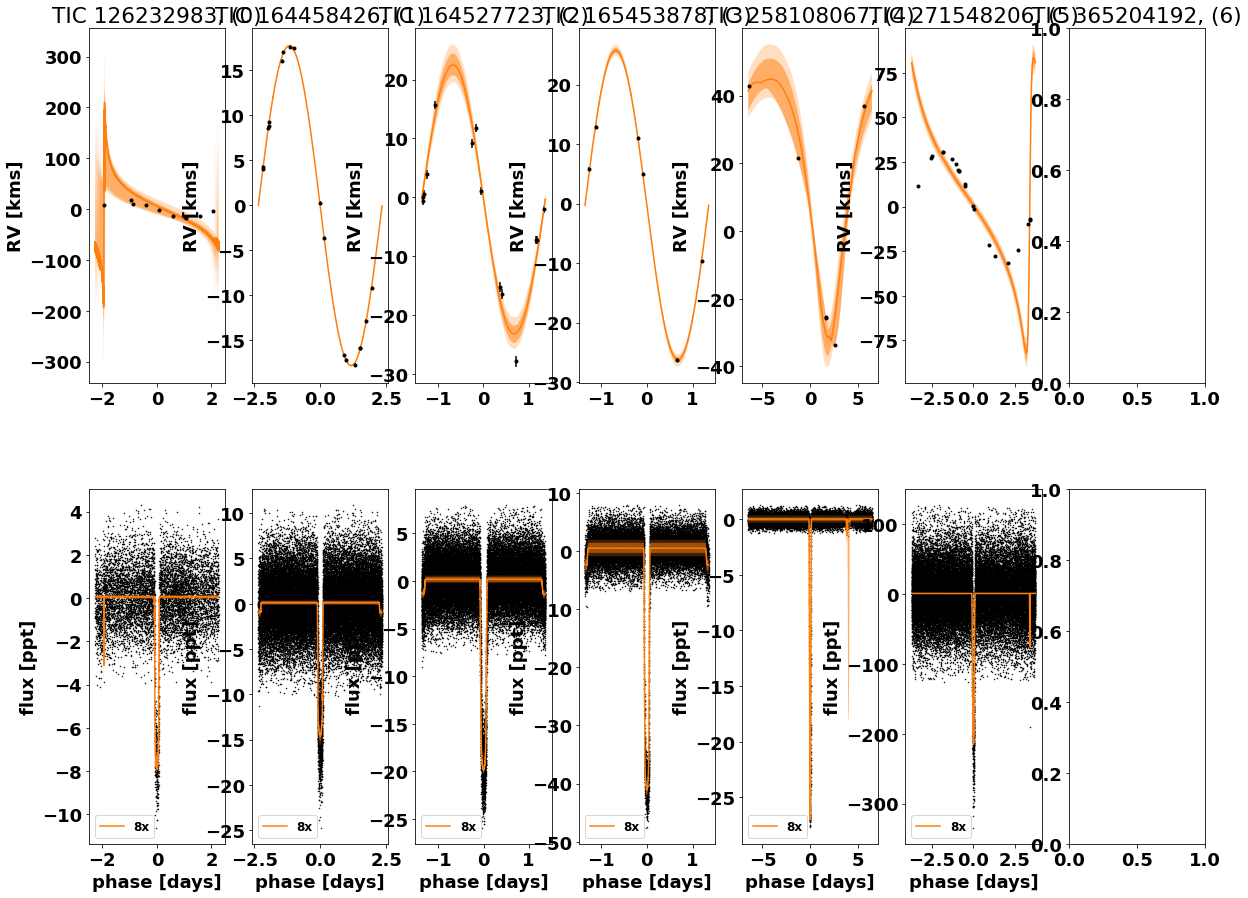

In [11]:
plot_targets = [f'TIC {id}' for id in tic_systems_of_interest[6:]]
# plot_targets = [f'TIC {id}' for id in ['20215452','164458426','165453878','258108067','271548206']]
plot_LC_RV_phased_curve_gallery(plot_targets, chains=8, Ntune=1000, Ndraw=500, model_list=['8x'],save_to_disk=True,Ncols=7,file_args='sf2')

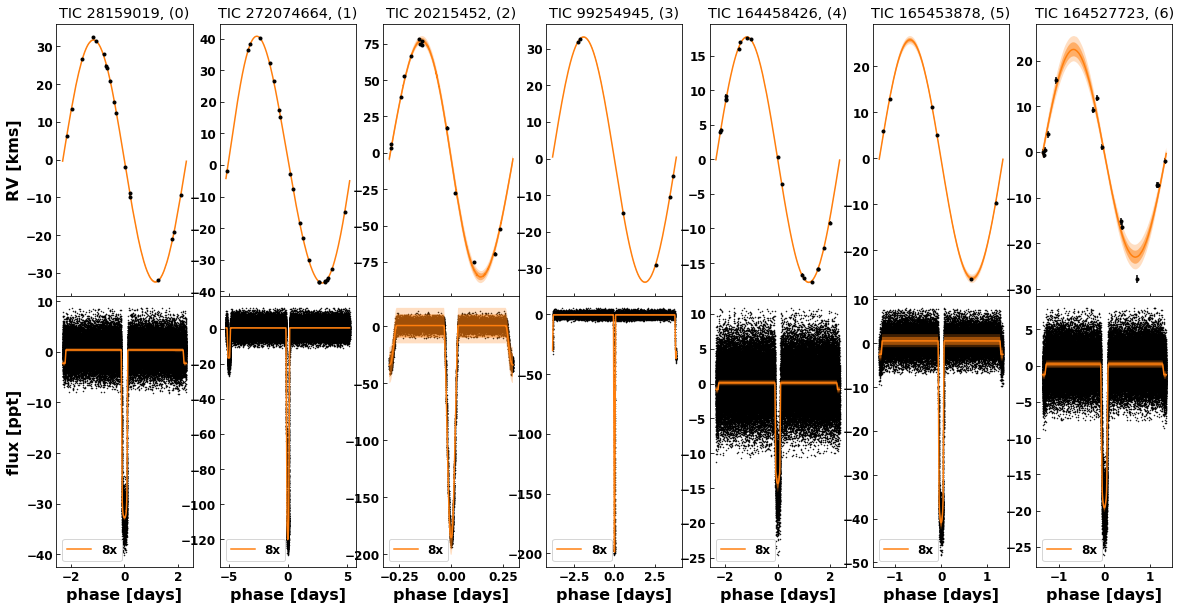

In [293]:
good_tic_systems_of_interest = [
    28159019,
    272074664,
    20215452,
    99254945,
    164458426,
    165453878,
    164527723,
    ]

rejects = [258108067, 271548206,126232983]
#list(set(tic_systems_of_interest).difference(set(good_tic_systems_of_interest)))
rejects = [f'TIC {id}' for id in rejects]
plot_targets = [f'TIC {id}' for id in good_tic_systems_of_interest]
# plot_targets = [f'TIC {id}' for id in ['20215452','164458426','165453878','258108067','271548206']]
rcParams['axes.labelsize'] = 16
rcParams['font.size'] = 12
fig,all_axes = plot_LC_RV_phased_curve_gallery(
    plot_targets, chains=6, Ntune=1500, Ndraw=750, model_list=['8x'],save_to_disk=True, Ncols=7)

# print(all_axes[:,1:])


In [252]:
def plot_3panel_LC_plot_gallery(TIC_TARGETs=['TIC 20215452'], Ntune=1000, Ndraw=500, chains=4,
                                model_list=['1x'], save_to_disk=False):
    
    
#     fig, all_axes = plt.subplots(figsize=(20,16), ncols=len(TIC_TARGETs), nrows=3, sharex=True)
    fig = plt.figure(figsize=(20,16))
    gs = GridSpec(nrows=1000,ncols=1000)
    axe1 = fig.add_subplot(gs[750:1000,0:950])
    axe2 = fig.add_subplot(gs[250:750,0:950])
    axe3 = fig.add_subplot(gs[:250,0:950])
    cbax = fig.add_subplot(gs[0:1000, 950:975])
    
    for jj, ticid in enumerate(TIC_TARGETs):
        if len(TIC_TARGETs)==1:
            axes = [axe3,axe2,axe1]
        else:
            axes = all_axes[:,jj]
        
#         print(axes)
        for ii, model_type in enumerate(model_list):

            modcol = 'cyan'#f"C{int((ii*0)+1)}"
            
            file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{ticid}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
            mv_res_dict = pk.load(file)
            file.close()

            flat_samps = mv_res_dict['trace'].posterior.stack(sample=('chain','draw'))
            x_rv = mv_res_dict['rvdat']['x_rv']
            y_rv = mv_res_dict['rvdat']['y_rv']
            yerr_rv = mv_res_dict['rvdat']['yerr_rv']

            x = mv_res_dict['lcdat']['x']
            y = mv_res_dict['lcdat']['y']
            yerr = mv_res_dict['lcdat']['yerr']

            gp_pred = mv_res_dict['gp_pred']

            trv = mv_res_dict['trv']
            tlc = mv_res_dict['tlc'] 

            rvvals = mv_res_dict['rvvals']
            lcvals = mv_res_dict['lcvals']
            
            p_med = flat_samps['period'].median().values
            t0_med = flat_samps['t0'].median().values
            mean_rv = flat_samps['mean_rv'].median().values
            mean_lc = flat_samps['mean_lc'].median().values

            
            pred = np.percentile(lcvals, [16, 50, 84], axis=0)
            print(pred.shape)

            print(p_med)
            hp = 1.0* p_med
            axes[0].set_title(f"{ticid}")
            axes[0].set_ylabel("flux [ppt]",fontsize=20)
            axes[1].set_ylabel("flux [ppt]",fontsize=20)
            axes[2].set_ylabel("flux [ppt]",fontsize=20)
            axes[0].set_xlim(-.60*hp, +.60*hp) 
            axes[1].set_xlim(-.60*hp, +.60*hp) 
            axes[2].set_xlim(-.60*hp, +.60*hp)

            ### first subplot - the unfolded time series with model
            #### (tn - t0) / Ntrans = PERIOD; tn = (period*Ntrans) + t0
#             tn_med = (p_med * 0) + t0_med
            norm = plt.Normalize()
            colors = plt.cm.inferno(norm(x-t0_med))
            tmin,tmax = min(x-t0_med), max(x-t0_med)
            
        
#             axes[0].errorbar((x - t0_med), y, yerr=yerr, fmt=".k",ecolor='gray', zorder=-1)

            print(np.median(np.diff(x)),np.median(np.diff(tlc)))
            axes[0].scatter((x-t0_med), y, c=colors, zorder=-1, marker='.',label='Obs')
            axes[0].plot(x-t0_med, gp_pred, ls='--', color='gold',lw=3,label='GP')
            axes[0].plot(tlc-t0_med, pred[1], color=modcol, zorder=2,lw=2,label='Mod')

  
            
            axes[0].legend(loc='best',fontsize=12)
            axes[0].tick_params(direction='in',labelbottom=False)
                         
            xlim1 = axes[0].set_xlim()
            ylim1 = axes[0].set_ylim()
            ylim_rng = max(ylim1)-min(ylim1)
            axes[0].text(0.95 * xlim1[1], min(ylim1) + abs(0.1*min(ylim1)),
                         "unfolded lightcurve",
                         horizontalalignment='right',
                         verticalalignment='top', fontsize=20)
            # rvvals = indres['rvvals']
            # lcvals = indres['lcvals']

            t_fold = fold(x, hp, t0_med)
#             t_fold = (x - t0_med + hp) % p_med - hp
            inds = np.argsort(t_fold)
#             axes[1].errorbar(t_fold,
#                           y, fmt=".k", ms=1, yerr=yerr, zorder=-1, ecolor='gray')
            axes[1].tick_params(direction='in',labelbottom=False)
            axes[1].scatter(t_fold[inds], y[inds], marker='.', c=colors[inds],zorder=-1)
            axes[1].text(-0.58*hp,y[min(inds)],'Obs', fontsize=16,
                         bbox=dict(boxstyle="round",
                        ec='black',
                        fc='whitesmoke'),
                        horizontalalignment='left', verticalalignment='top')
        
            axes[1].scatter(t_fold[inds], gp_pred[inds]+ylim_rng, c=colors[inds],marker='o', s=0.1)
            axes[1].text(-0.58*hp,gp_pred[min(inds)]+ylim_rng,'GP, offset', fontsize=16,
                         bbox=dict(boxstyle="round",
                        ec='black',
                        fc='whitesmoke'),
                        horizontalalignment='left', verticalalignment='top')
#             axes[1].set_xlim(-t0_med, t0_med)
#             axes[1].set_xlim(-t0_med, t0_med) 
            axes[1].set_ylim(min(ylim1), max(ylim1)+ylim_rng)
#             t_fold = (tlc - t0_med + hp) % p_med - hp
            t_fold = fold(tlc, p_med, t0_med)
            inds = np.argsort(t_fold)
            modcolors = plt.cm.Blues_r(norm(tlc-t0_med))

            cbar_src = axes[1].scatter(t_fold[inds], pred[1][inds] + .5*ylim_rng, 
                                       c=tlc[inds], zorder=2, marker='o', s=0.75,
                                       cmap='inferno', vmin=0 , vmax=max(tlc)-min(tlc))
            axes[1].text(-0.58*hp,pred[1][min(inds)] + .5*ylim_rng,'Mod, offset', fontsize=16,
                         bbox=dict(boxstyle="round",
                        ec='black',
                        fc='whitesmoke'),
                        horizontalalignment='left', verticalalignment='bottom')
            cbar_ = plt.colorbar(cbar_src, cax=cbax)
            cbar_.set_label("Days", fontsize=20)
            
            axes[1].text(0.95 * xlim1[1], min(ylim1) + abs(0.15*min(ylim1)),
                         "folded lightcurve, no GP subtraction",
                         horizontalalignment='right',
                         verticalalignment='top', fontsize=20,)
            
            
#             t_fold = (x - t0_med + hp) % p_med - hp 
            t_fold = fold(x, hp, t0_med)
            inds = np.argsort(t_fold)
            axes[2].tick_params(direction='in')


#             axes[2].errorbar(t_fold[inds],
#                           y[inds]-gp_pred[inds], fmt=".k", yerr=yerr, ms=1, zorder=-1, ecolor='gray')
            axes[2].scatter(t_fold[inds], y[inds]-gp_pred[inds], marker='.', c=colors[inds], zorder=-1,
                           label='Obs - GP')
#             t_fold = (tlc - t0_med + hp) % p_med - hp
            t_fold = hf.fold(tlc, hp, t0_med)
            inds = np.argsort(t_fold)
            pred = np.percentile(lcvals, [16, 50, 84], axis=0)
            axes[2].plot(t_fold[inds], pred[1][inds], color=modcol, zorder=2, lw=3,
                        label='Mod')
            axes[2].legend(loc='best',fontsize=12)

            xlim1 = axes[2].set_xlim()
            ylim1 = axes[2].set_ylim()
            axes[2].text(0.95 * xlim1[1], min(ylim1) + abs(0.1*min(ylim1)),
                         "folded lightcurve, full GP subtraction",
                         horizontalalignment='right',
                         verticalalignment='top', fontsize=20)

 



            axes[2].set_xlabel("phase [days]", fontsize=20)
    fig.subplots_adjust(hspace=0.0)
    if save_to_disk:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/{'_'.join(TIC_TARGETs).replace(' ','_')}_LC_curves.png", bbox_inches='tight', dpi=150)
        

(3, 5000)
0.5957554274822363
0.0013888773278267763 0.005297951838320714


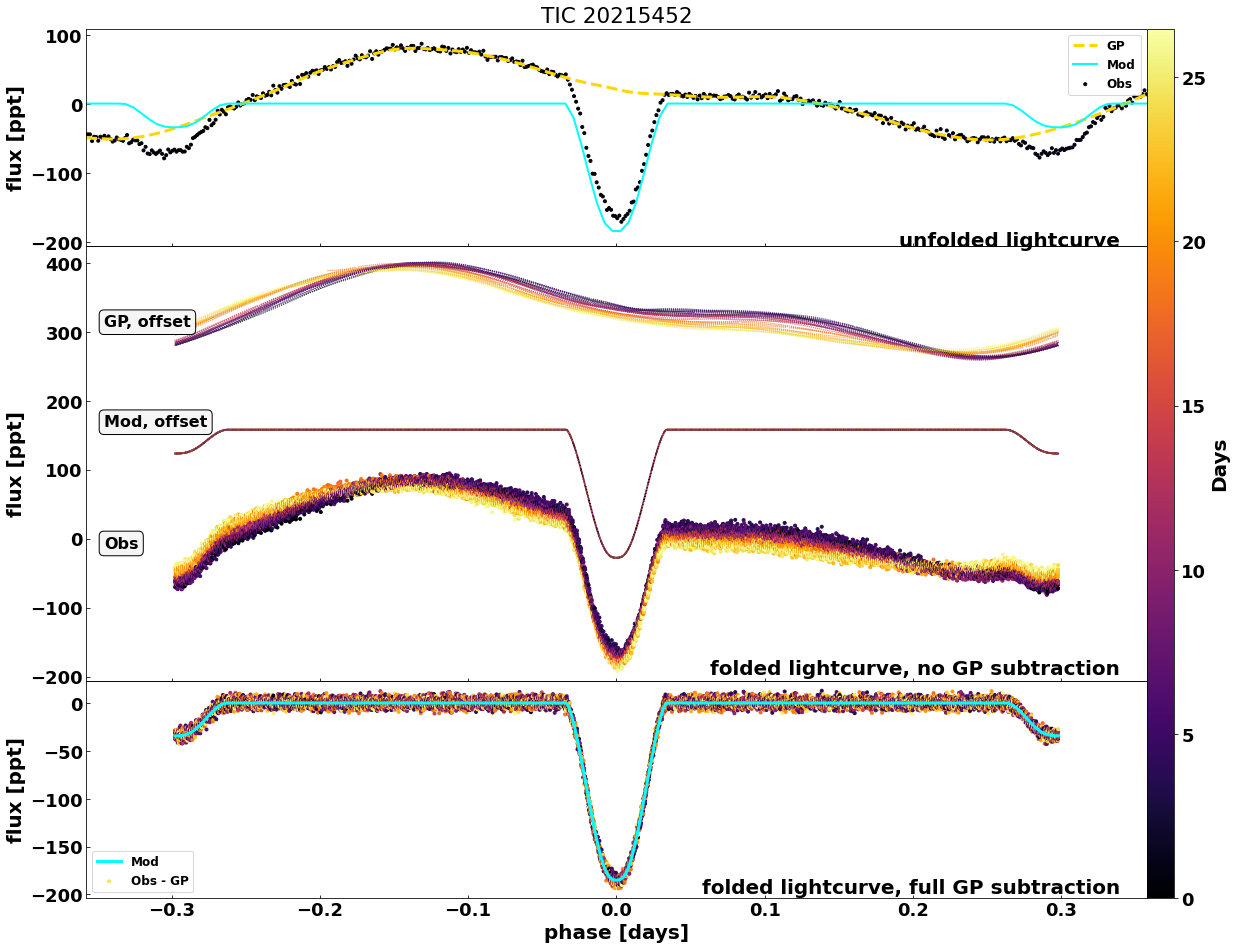

In [253]:
plot_3panel_LC_plot_gallery(TIC_TARGETs=['TIC 20215452'], Ntune=1500, Ndraw=750, chains=6, model_list=['8x'], save_to_disk=True)

No handles with labels found to put in legend.


-0.29 214.37
<Table length=190>
 name   dtype      unit                  description                  class     n_bad
------ ------- ------------ -------------------------------------- ------------ -----
   Seq   int64                     [1/95] System sequential number       Column     0
  Name   str15           --             Star name of the component MaskedColumn     1
   Per float64            d                Period of the component       Column     0
 u_Per    str1                             Uncertainty flag on Per MaskedColumn   188
 x_Per    str1                            [y] y if period in years MaskedColumn   189
  Comp    str1                                      [AB] Component       Column     0
SpType    str8         ----      MK spectral type of the component       Column     0
  Mass float64         Msun                  Mass of the component       Column     0
e_Mass float64         Msun                rms uncertainty on Mass       Column     0
   Rad float64        

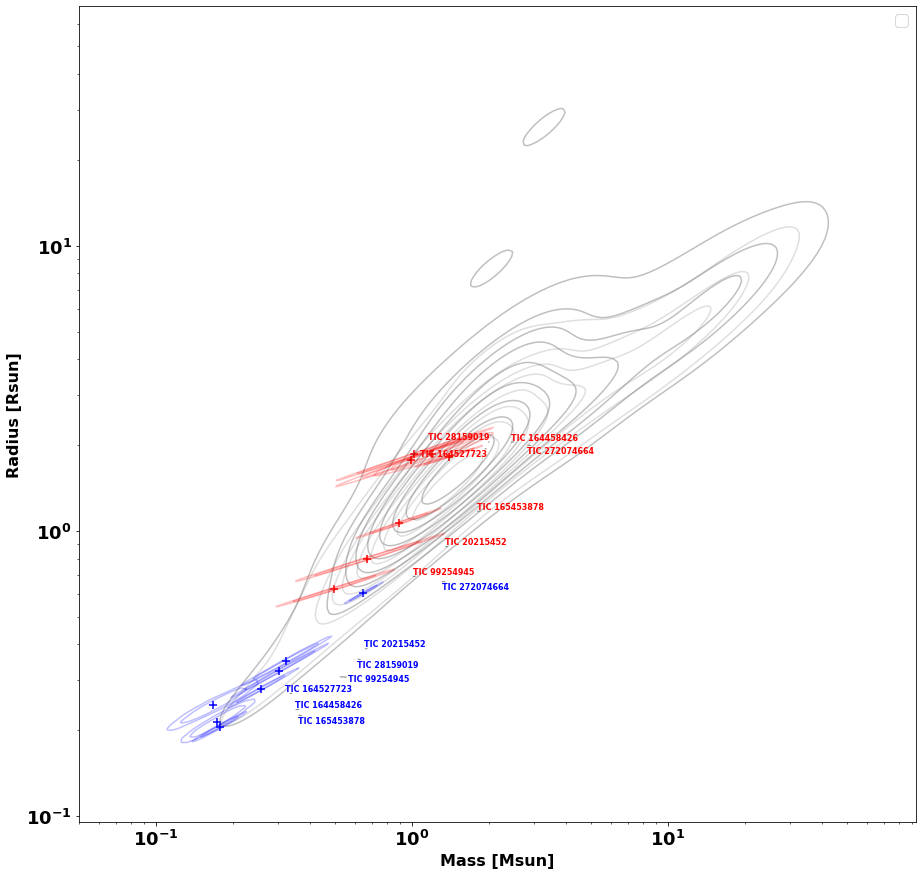

In [14]:
def plot_all_mass_radii_contours(TIC_LIST=None,Ntune=1000, Ndraw=500, chains=4,
                                model_type='1x', save_to_disk=False):
    import scipy.stats as st
    import seaborn as sns
    if TIC_LIST is None:
        TIC_LIST = [
                        28159019,
                        272074664,
                        20215452,
                        99254945,
#                         144441148,
                        169820068,
#                         126232983,
                        164458426,
                        164527723,
                        165453878,
                        258108067,
                        271548206,
                        365204192
                        ]
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot()
    
    #Table 1 from Willy Torres' review article on detached eclipsing binaries
    #https://ui.adsabs.harvard.edu/abs/2010A%26ARv..18...67T/abstract
    from astropy.table import Table
    tor = Table.read("https://cdsarc.cds.unistra.fr/ftp/J/other/A+ARV/18.67/table1.dat",
                 readme="https://cdsarc.cds.unistra.fr/ftp/J/other/A+ARV/18.67/ReadMe",
                 format="ascii.cds")
    
    mass = tor["Mass"]
    e_mass = tor["e_Mass"]
    radius = tor["Rad"]
    e_radius = tor["e_Rad"]
    pri = tor["Comp"] == 'A' #primaries
    sec = tor["Comp"] == 'B' #secondaries
    print(min(tor['Per']),max(tor['Per']))
    tor.info()
#     ax.errorbar(mass[pri], radius[pri], xerr=e_mass[pri], yerr=e_radius[pri], 
#                 fmt='.', ms=2,ecolor='red',mec='red',mfc='red',label='Primaries',alpha=0.25)
#     ax.errorbar(mass[sec], radius[sec], xerr=e_mass[sec], yerr=e_radius[sec], 
#                 fmt='.', ms=2,ecolor='blue',mec='blue',mfc='blue',label='Secondaries',alpha=0.25)
    sns.kdeplot(x=mass[pri],y=radius[pri],fill=False,color='black',alpha=0.25,ax=ax,log_scale=True)
    sns.kdeplot(x=mass[sec],y=radius[sec],fill=False,color='gray',alpha=0.25,ax=ax,log_scale=True)
    ax.legend(loc='best',fontsize=16)
    ax.set_xlabel("Mass [Msun]",fontsize=16)
    ax.set_ylabel("Radius [Rsun]",fontsize=16)
    ax.set_xlim(xmin=0.05)

    ax.set_xscale('log')
    ax.set_yscale('log')
    
    x1,x2 = ax.set_xlim()
    print(x1,x2)
    y1,y2 = ax.set_ylim()
    
    label_list = []
    for ticid in TIC_LIST:
        try:
            file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/TIC {ticid}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
            mv_res_dict = pk.load(file)
            file.close()
            flat_samps = mv_res_dict['trace'].posterior.stack(sample=('chain','draw'))
            fs_df = flat_samps
#             print(fs_df.columns)
            m1 = flat_samps['M1'].values
            r1 = flat_samps['R1'].values
            m2 = (flat_samps['M2'].values)
            r2 = (flat_samps['R2'].values)
#             print(len(m1),len(r1),len(m2),len(r2))

            m1min,m1med,m1max = np.percentile(m1,[25,50, 75])
            r1min,r1med,r1max = np.percentile(r1,[25,50, 75])

            m2min,m2med,m2max = np.percentile(m2,[25,50, 75])
            r2min,r2med,r2max = np.percentile(r2,[25,50, 75])

            print(f"mass1 acc: {abs(m1max-m1med)/m1med:3f}, {abs(m1min-m1med)/m1med:3f}")
#             m1xx,r1yy = np.mgrid[m1min:m1max:100j, r1min:r1max:100j]
#             p_pos = np.vstack([m1xx.ravel(), r1yy.ravel()])
#             p_vals = np.vstack([m1,r1])
#             p_kern = st.gaussian_kde(p_vals)
#             p_f = np.reshape(p_kern(p_pos).T, m1xx.shape)


#             m2xx,r2yy = np.mgrid[m2min:m2max:100j, r2min:r2max:100j]
#             s_pos = np.vstack([m2xx.ravel(), r2yy.ravel()])
#             s_vals = np.vstack([m2,r2])
#             s_kern = st.gaussian_kde(s_vals)
#             s_f = np.reshape(s_kern(s_pos).T, m2xx.shape)


#             p_cset = ax.contour(m1xx,r1yy, p_f, colors='r',levels=2,alpha=0.25,zorder=-1)
            sns.kdeplot(x=m1,y=r1,fill=False,levels=[0.25,0.5],color='r',alpha=0.25,ax=ax,log_scale=True)
            ax.scatter(m1med,r1med,marker='+',color='r',s=50)
#             ax.text(x2+0.1*x2, r1med, f"TIC {ticid}",color='r',fontsize=8)
            label_list.append(ax.text(m1med+1*m1med, r1med+0.1*r1med, f"TIC {ticid}",color='r',fontsize=8))
#             s_cset = ax.contour(m2xx,r2yy, s_f, colors='b',levels=2,alpha=0.25,zorder=-1)
            sns.kdeplot(x=m2,y=r2,fill=False,levels=[0.25,0.5],color='b',alpha=0.25,ax=ax,log_scale=True)
            ax.scatter(m2med,r2med,marker='+',color='b',s=50)
            label_list.append(ax.text(m2med+1*m2med, r2med+0.1*r2med, f"TIC {ticid}",color='b',fontsize=8))
            

        except:
            continue
    adjust_text(label_list, arrowprops=dict(arrowstyle="-", color='gray', lw=1))
#     plt.show()


    mod_str = f"Nc{chains}Nt{Ntune}Nd{Ndraw}"
    if save_to_disk:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/good_systems_{mod_str}_MR_contours.png", bbox_inches='tight', dpi=150)
plot_all_mass_radii_contours(Ntune=1500, Ndraw=750, chains=6, model_type='8x',save_to_disk=True)

11.757270188948421 12.812274270849151 13.92681129620133
24.629735580222736 25.5387514423781 26.461949737385357
2.737481997458462 2.966718658547783 3.208090233785491
14.077932563316939 14.947325694683059 15.92412296213398
12.27855312349584 13.115031410830035 14.06976503018662
8.038693096174317 8.657372444146535 9.324468902449311
7.985348011921326 8.347239334889576 8.723758711754506


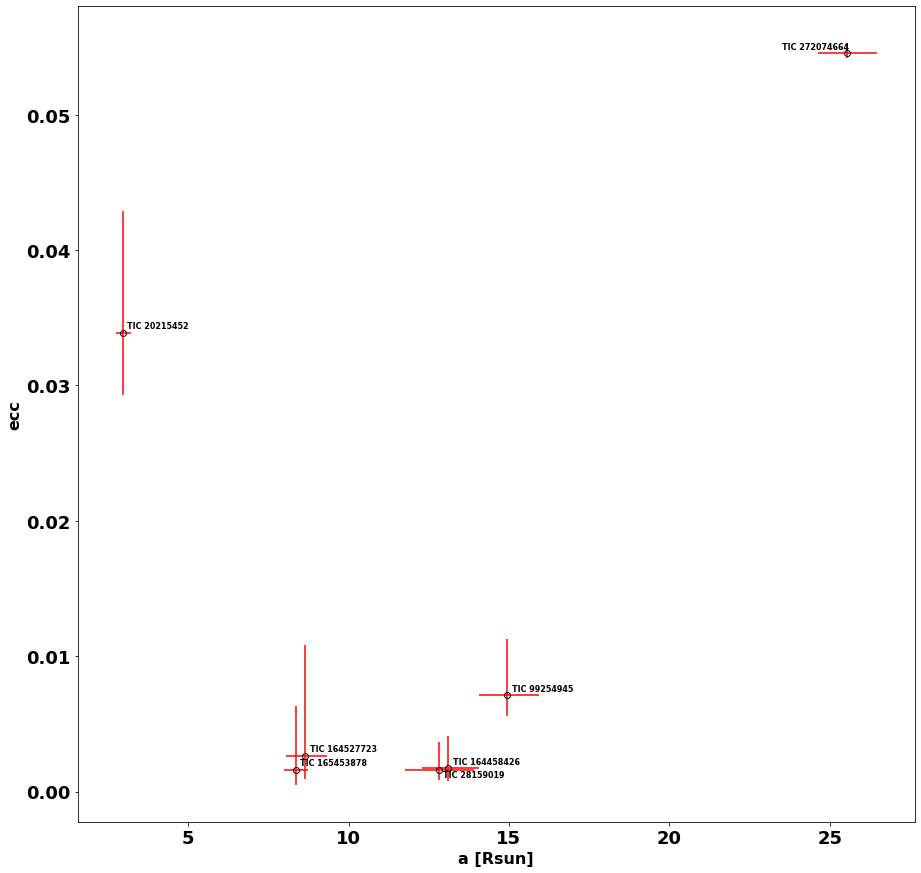

In [17]:
def plot_two_cols(TIC_LIST=None,Ntune=1000, Ndraw=500, chains=4,
                                model_type='1x', save_to_disk=False, cols=('period','ecc')):
    import scipy.stats as st
    import seaborn as sns
    if TIC_LIST is None:
        TIC_LIST = [
                        28159019,
                        272074664,
                        20215452,
                        99254945,
#                         144441148,
                        169820068,
#                         126232983,
                        164458426,
                        164527723,
                        165453878,
                        258108067,
                        271548206,
                        365204192
                        ]
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.gca()
    ax.set_xlabel(f"{cols[0]} [Rsun]",fontsize=16)
    ax.set_ylabel(f"{cols[1]}",fontsize=16)
    label_list = []
    for ticid in TIC_LIST:
        try:
            file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/TIC {ticid}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
            mv_res_dict = pk.load(file)
            file.close()
            flat_samps = mv_res_dict['trace'].posterior.stack(sample=('chain','draw'))
            
#             print(fs_df.columns)
            m1 = flat_samps[cols[0]].values
            r1 = flat_samps[cols[1]].values

#             print(len(m1),len(r1),len(m2),len(r2))

            m1min,m1med,m1max = np.percentile(m1,[25,50, 75])
            r1min,r1med,r1max = np.percentile(r1,[25,50, 75])
            print(m1min,m1med,m1max)

#             m1xx,r1yy = np.mgrid[m1min:m1max:100j, r1min:r1max:100j]
#             p_pos = np.vstack([m1xx.ravel(), r1yy.ravel()])
#             p_vals = np.vstack([m1,r1])
#             p_kern = st.gaussian_kde(p_vals)
#             p_f = np.reshape(p_kern(p_pos).T, m1xx.shape)


#             m2xx,r2yy = np.mgrid[m2min:m2max:100j, r2min:r2max:100j]
#             s_pos = np.vstack([m2xx.ravel(), r2yy.ravel()])
#             s_vals = np.vstack([m2,r2])
#             s_kern = st.gaussian_kde(s_vals)
#             s_f = np.reshape(s_kern(s_pos).T, m2xx.shape)


#             p_cset = ax.contour(m1xx,r1yy, p_f, colors='r',levels=2,alpha=0.25,zorder=-1)
#             sns.kdeplot(x=m1,y=r1,fill=False,color='r',alpha=0.25,ax=ax)
#             ax.scatter(m1med,r1med,marker='+',color='r')
            ax.errorbar(m1med,r1med, xerr=[[m1med-m1min], [m1max-m1med]],
                                    yerr=[[r1med-r1min], [r1max-r1min]],
                                    fmt='o',ecolor='red',mec='black',mfc='None')
#             plt.gcf().text(0.02, 1., f"TIC {ticid}", fontsize=10)
            label_list.append(ax.text(m1med+0.1,r1med+0.0001,
                    f"TIC {ticid}",fontsize=8,
                    horizontalalignment='left',
                    verticalalignment='bottom'))
# #             s_cset = ax.contour(m2xx,r2yy, s_f, colors='b',levels=2,alpha=0.25,zorder=-1)
#             sns.kdeplot(x=m2,y=r2,fill=False,levels=3,color='b',alpha=0.25,ax=ax)
#             ax.scatter(m2med,r2med,marker='+',color='b')
        except:
            continue
    adjust_text(label_list)
    
    mod_str = f"Nc{chains}Nt{Ntune}Nd{Ndraw}"
    if save_to_disk:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/good_systems_{mod_str}_{cols[0]}_{cols[1]}_errorbars.png", bbox_inches='tight', dpi=150)
plot_two_cols(Ntune=1500, Ndraw=750, chains=6, model_type='8x',cols=('a','ecc'), save_to_disk=True)    

Msun d
m3 / (kg s2)


No handles with labels found to put in legend.


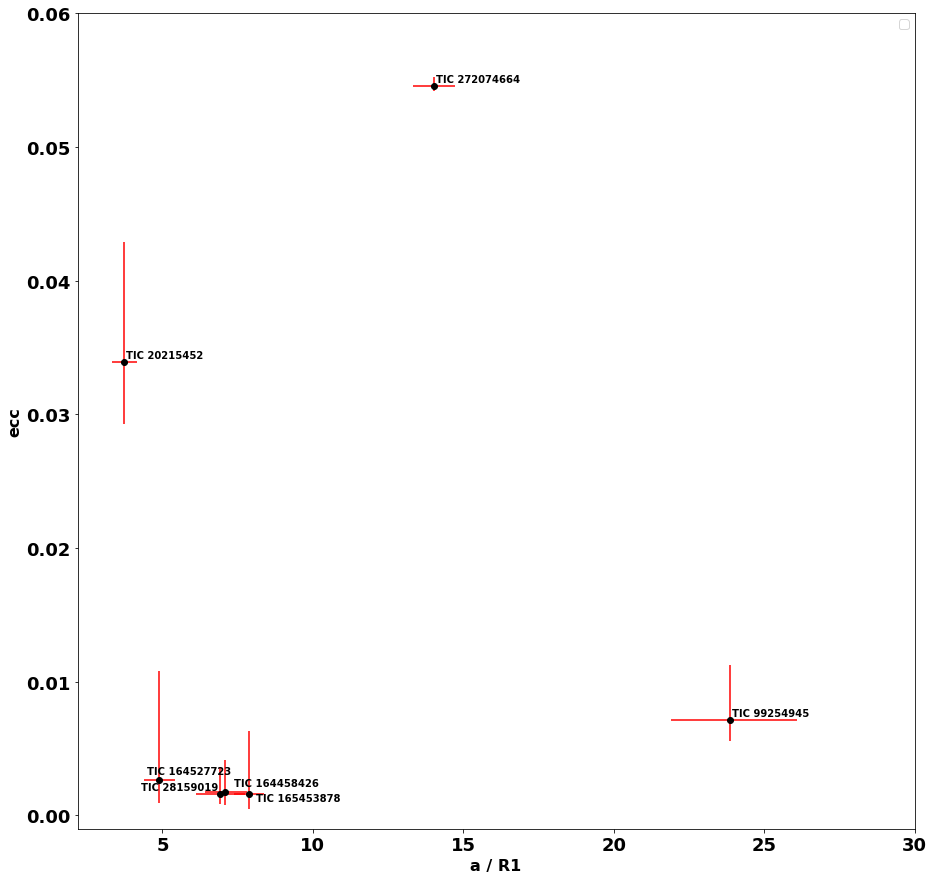

In [19]:

def plot_scaled_a_vs_ecc(TIC_LIST=None,Ntune=1000, Ndraw=500, chains=4,
                                model_type='1x', save_to_disk=False):
    import scipy.stats as st
    import seaborn as sns
    if TIC_LIST is None:
        TIC_LIST = [
                        28159019,
                        272074664,
                        20215452,
                        99254945,
#                         144441148,
                        169820068,
#                         126232983,
                        164458426,
                        164527723,
                        165453878,
                        258108067,
                        271548206,
                        365204192
                        ]
    
    tor = astab.Table.read("https://cdsarc.cds.unistra.fr/ftp/J/other/A+ARV/18.67/table1.dat",
                 readme="https://cdsarc.cds.unistra.fr/ftp/J/other/A+ARV/18.67/ReadMe",
                 format="ascii.cds")

    tor3 = astab.Table.read("https://cdsarc.cds.unistra.fr/ftp/J/other/A+ARV/18.67/table3.dat",
                 readme="https://cdsarc.cds.unistra.fr/ftp/J/other/A+ARV/18.67/ReadMe",
                 format="ascii.cds")

    mass = tor["Mass"]
    e_mass = tor["e_Mass"]
    radius = tor["Rad"]
    e_radius = tor["e_Rad"]
    pri = tor["Comp"] == 'A' #primaries
    sec = tor["Comp"] == 'B' #secondaries
    per = tor['Per']
    print(mass.unit, per.unit)
    def spit_out_circorbit_a(m1,m2,per):

        g = astropy.constants.G
        print(g.unit)
    #     a3/ p2 = G (M1 + M2) / 4 pi

        a = ( per.to(u.second)**2. * (g * (m1.to(u.kg)+m2.to(u.kg))) / (4.*np.pi**2.)) ** (1./3)

        return a

    torres_a = spit_out_circorbit_a(mass[pri],mass[sec],per[pri])
    torres_scaled_a = torres_a.to(u.Rsun).value / radius[pri].to(u.Rsun).value
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.add_subplot()
    ax.set_xlabel("a / R1",fontsize=16)
    ax.set_ylabel('ecc',fontsize=16)
    
#     sns.rugplot(x=torres_scaled_a,ax=ax, c='black', label='Torres 2010')
    
    label_list = []
    x_vals = []
    y1_vals = []
    y2_vals = []
    for ticid in TIC_LIST:
        try:
            file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/TIC {ticid}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
            mv_res_dict = pk.load(file)
            file.close()
            flat_samps = mv_res_dict['trace'].posterior.stack(sample=('chain','draw'))
            
            
            
            
            f = 1.
            M1 = flat_samps['M1'].median().values * u.Msun
            R1 = flat_samps['R1'].median().values * u.Rsun
            q = flat_samps['q'].median().values# * (u.Msun/u.Msun)
            a = flat_samps['a'].median().values * u.Rsun
            L1 = 0.23*(M1.to(u.Msun).value)**2.3 if M1 < 0.43*u.Msun else (M1.to(u.Msun).value) ** 4.0
            L1 = L1 * u.Lsun
            Menv = M1 * 0.1

            tc_inv = f * ( (L1) / (Menv*R1**2) ) ** (1/3.) * (Menv/M1) * q*(1+q) * (R1/a) ** 8.

            y2_vals.append((tc_inv.decompose() ** -1).to(u.year).value)
#             print(fs_df.columns)
            ecc = flat_samps['ecc'].values
            a = flat_samps['a'].values * u.Rsun
            r1 = flat_samps['R1'].values * u.Rsun
        
#             scaled_a = (a/r1).decompose()
#             print((a/r1).unit)
            amin,amed,amax = np.percentile(a,[25,50,75])
            r1min,r1med,r1max = np.percentile(r1,[25,50,75])
        
            xmed = (amed/r1med).decompose().value
            xmin = xmed * np.sqrt(((r1med-r1min)/r1med)**2. + ((amed-amin)/amed)**2.).decompose().value
            xmax = xmed * np.sqrt(((r1max-r1med)/r1med)**2. + ((amax-amed)/amed)**2.).decompose().value


#             xmin,xmed,xmax = np.percentile(scaled_a,[25,50, 75])
            ymin,ymed,ymax = np.percentile(ecc,[25,50, 75])
#             print(m1min,m1med,m1max)

            ax.errorbar(xmed,ymed, xerr=[[xmin], [xmax]],
                                    yerr=[[ymed-ymin], [ymax-ymin]],
                                    fmt='o',ecolor='red',mec='black',mfc='black')
            x_vals.append(xmed)
            y1_vals.append(ymed)
            
#             plt.gcf().text(0.02, 1., f"TIC {ticid}", fontsize=10)
            label_list.append(ax.text(xmed,ymed+0.0001,
                    f"TIC {ticid}",fontsize=10,
                    horizontalalignment='left',
                    verticalalignment='bottom'))
# #             s_cset = ax.contour(m2xx,r2yy, s_f, colors='b',levels=2,alpha=0.25,zorder=-1)
#             sns.kdeplot(x=m2,y=r2,fill=False,levels=3,color='b',alpha=0.25,ax=ax)
#             ax.scatter(m2med,r2med,marker='+',color='b')
        except:
            continue
#     ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
#     ax2.scatter(x_vals, np.log10(y2_vals))
#     ax2.set_ylabel("t_circ [log10 yr]")
    ax.set_xlim(xmax=30)
    ax.set_ylim(ymin=-0.001,ymax=0.06)
    ax.legend(loc='upper right', fontsize=12)
    adjust_text(label_list)
    
    mod_str = f"Nc{chains}Nt{Ntune}Nd{Ndraw}"
    if save_to_disk:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/good_systems_{mod_str}_scaled_a_vs_ecc_errorbars.png", bbox_inches='tight', dpi=150)

        
plot_scaled_a_vs_ecc(Ntune=1500, Ndraw=750, chains=6, model_type='8x', save_to_disk=True)

In [20]:
#Table 1 from Willy Torres' review article on detached eclipsing binaries
#https://ui.adsabs.harvard.edu/abs/2010A%26ARv..18...67T/abstract
from astropy.table import Table
tor = Table.read("https://cdsarc.cds.unistra.fr/ftp/J/other/A+ARV/18.67/table1.dat",
             readme="https://cdsarc.cds.unistra.fr/ftp/J/other/A+ARV/18.67/ReadMe",
             format="ascii.cds")

tor3 = Table.read("https://cdsarc.cds.unistra.fr/ftp/J/other/A+ARV/18.67/table3.dat",
             readme="https://cdsarc.cds.unistra.fr/ftp/J/other/A+ARV/18.67/ReadMe",
             format="ascii.cds")

print(tor.keys(), tor3.keys())


print(len(astab.unique(tor,keys='Per')))
mass = tor["Mass"]
e_mass = tor["e_Mass"]
radius = tor["Rad"]
e_radius = tor["e_Rad"]
pri = tor["Comp"] == 'A' #primaries
sec = tor["Comp"] == 'B' #secondaries
per = tor['Per']

totmass = mass[pri] + mass[sec]
print(totmass.unit)
only_pri = tor[pri]
only_pri['mtot'] = only_pri['Mass']
only_pri['mtot'] = totmass
print(only_pri.info())

joined_t1_t3 = astab.join(only_pri, tor3, keys=('Seq','Seq'),join_type='right')
print(joined_t1_t3.info())
# print(mass.unit, per.unit)
def spit_out_circorbit_a(m,per):

    g = astropy.constants.G
    print(g.unit)
#     a3/ p2 = G (M1 + M2) / 4 pi

    a = ( per.to(u.second)**2. * (g * (m.to(u.kg))) / (4.*np.pi**2.)) ** (1./3)
    
    return a
from collections import Counter
# print(Counter(tor['Name']))
a = spit_out_circorbit_a(mass[pri]+mass[sec],per[pri]).decompose()
# print(tor,tor3['Name'],len(a))

['Seq', 'Name', 'Per', 'u_Per', 'x_Per', 'Comp', 'SpType', 'Mass', 'e_Mass', 'Rad', 'e_Rad', 'Teff', 'e_Teff', 'logg', 'e_logg', 'logL', 'e_logL', 'VMAG', 'e_VMAG'] ['Seq', 'Name', 'Ecc', 'e_Ecc', 'dw/dt', 'e_dw/dt', 'logK2', 'e_logK2', 'Flag', 'Ref', 'n_Ref']
169
Msun
<Table length=95>
 name   dtype      unit                  description                  class     n_bad
------ ------- ------------ -------------------------------------- ------------ -----
   Seq   int64                     [1/95] System sequential number       Column     0
  Name   str15           --             Star name of the component MaskedColumn     0
   Per float64            d                Period of the component       Column     0
 u_Per    str1                             Uncertainty flag on Per MaskedColumn    95
 x_Per    str1                            [y] y if period in years MaskedColumn    94
  Comp    str1                                      [AB] Component       Column     0
SpType    str8         -

In [21]:
def rerun_model_evaluation(TIC_TARGET=None,Ntune=1000, Ndraw=500, chains=6,model_type='1x'):
    file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
    mv_res_dict = pk.load(file)
    file.close()

    def compute_value_in_post(model, idata, target, size=None):
        # Get the names of the untransformed variables
        vars = get_default_varnames(model.unobserved_RVs, True)
        names = list(sorted(set([
            get_untransformed_name(v.name)
            if is_transformed_name(v.name)
            else v.name
            for v in vars
        ])))

        # Compile a function to compute the target
        func = theano.function([model[n] for n in names], target, on_unused_input="ignore")

        # Call this function for a bunch of values
        flat_samps = idata.posterior.stack(sample=("chain", "draw"))
        if size is None:
            indices = np.arange(len(flat_samps.sample))
        else:
            indices = np.random.randint(len(flat_samps.sample), size=size)

        return [func(*(flat_samps[n].values[..., i] for n in names)) for i in indices]

    

    with mv_res_dict['model'] as mod:
        def model_lc(t):
            return (
                mean_lc
                + 1e3
                * lc.get_light_curve(orbit=orbit, r=R2, t=t, texp=texp)[:,0]
            )
        extras = dict(
            model_lc = model_lc
        )
    
    lcx = mv_res_dict['lcdat']['x']
    med_spacing = np.median(np.diff(lcx))
    hr_eval_grid = np.arange(min(lcx),max(lcx),med_spacing)
    
    lcvals = compute_value_in_post(mv_res_dict['model'], mv_res_dict['trace'], extras['model_lc'](hr_eval_grid), size=512)
    
    return lcvals

In [22]:
def calculate_tcirc_from_pymc3(DD=None,TIC_TARGET=None,Ntune=1000, Ndraw=500, chains=6,model_type='1x'):
    if DD is None:
        import helper_functions as hf

        DD = hf.load_system_specific_directory()
    
    file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
    mv_res_dict = pk.load(file)
    file.close()
    
    flat_samps = mv_res_dict['trace'].posterior.stack(sample=("chain", "draw"))
    
    f = 1.
    M1 = flat_samps['M1'].median().values * u.Msun
    R1 = flat_samps['R1'].median().values * u.Rsun
    q = flat_samps['q'].median().values# * (u.Msun/u.Msun)
    a = flat_samps['a'].median().values * u.Rsun
    L1 = 0.23*(M1.to(u.Msun).value)**2.3 if M1 < 0.43*u.Msun else (M1.to(u.Msun).value) ** 4.0
    L1 = L1 * u.Lsun
    Menv = M1 * 0.1
    
    tc_inv = f * ( (L1) / (Menv*R1**2) ) ** (1/3.) * (Menv/M1) * q*(1+q) * (R1/a) ** 8.
    
    return (tc_inv.decompose() ** -1)


def calculate_p_surf_from_pymc3(DD=None,TIC_TARGET=None,Ntune=1000, Ndraw=500, chains=6,model_type='1x'):
    if DD is None:
        import helper_functions as hf

        DD = hf.load_system_specific_directory()
    
    file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/{TIC_TARGET}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
    mv_res_dict = pk.load(file)
    file.close()
    
    flat_samps = mv_res_dict['trace'].posterior.stack(sample=("chain", "draw"))
    
    M1 = flat_samps['M1'].median().values * u.Msun
    M2 = flat_samps['M2'].median().values * u.Msun
    R1 = flat_samps['R1'].median().values * u.Rsun
    ecc = flat_samps['ecc'].median().values# * (u.Msun/u.Msun)
#     a = flat_samps['a'].median().values * u.Rsun

    g = astropy.constants.G
    
    psurf = 2.*np.pi * (g * (M1+M2)/(R1**3.)) ** (-.5) * (1 - ecc)**(-3./2.)
    
    return psurf.decompose()


In [23]:
from isochrones import BinaryStarModel
TIC_TARGET = 'TIC 20215452'
ID = TIC_TARGET.split(' ')[1]
mod = BinaryStarModel.load_hdf(f"/Users/kjaehnig/CCA_work/GAT/pymultinest_fits/tic_{ID}_binary_model_obj.hdf")

tcirc = calculate_tcirc_from_pymc3(TIC_TARGET="TIC 20215452", Ntune=1500, Ndraw=750, chains=6, model_type='8x')
tcirc.to(u.year)
psurf = calculate_p_surf_from_pymc3(TIC_TARGET="TIC 20215452", Ntune=1500, Ndraw=750, chains=6, model_type='8x')
psurf


Holoviews not imported. Some visualizations will not be available.


running on macOS
running on macOS


<Quantity 7550.51093562 s>

<Table length=44>
  name   dtype      unit                    description                    class     n_bad
------- ------- ------------ ------------------------------------------ ------------ -----
    Seq   int64                         [1/95] System sequential number       Column     0
 Name_1   str15           --                 Star name of the component MaskedColumn     0
    Per float64            d                    Period of the component       Column     0
  u_Per    str1                                 Uncertainty flag on Per MaskedColumn    44
  x_Per    str1                                [y] y if period in years MaskedColumn    43
   Comp    str1                                          [AB] Component       Column     0
 SpType    str8         ----          MK spectral type of the component       Column     0
   Mass float64         Msun                      Mass of the component       Column     0
 e_Mass float64         Msun                    rms uncertainty on Mass 

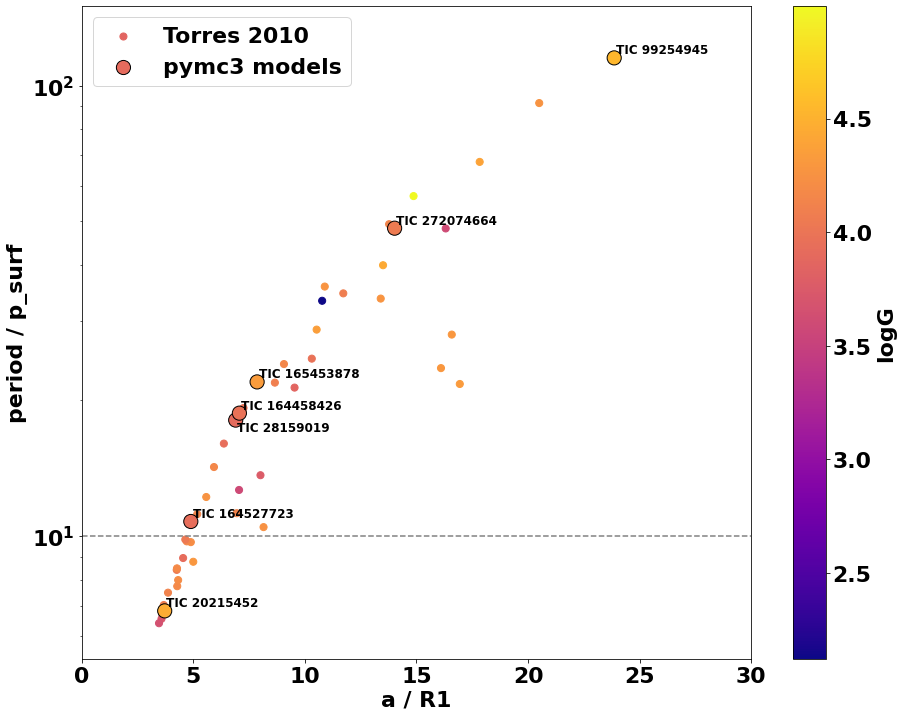

In [279]:
def plot_scaled_a_vs_psurf(TIC_LIST=None,Ntune=1000, Ndraw=500, chains=4,
                                model_type='1x', save_to_disk=False):
    import scipy.stats as st
    import seaborn as sns
    if TIC_LIST is None:
        TIC_LIST = [
                        28159019,
                        272074664,
                        20215452,
                        99254945,
#                         144441148,
                        169820068,
#                         126232983,
                        164458426,
                        164527723,
                        165453878,
                        258108067,
                        271548206,
                        365204192
                        ]
        
    fig = plt.figure(figsize=(15,12))
    ax = fig.add_subplot()
    ax.set_xlabel("a / R1")
    ax.set_ylabel('period / p_surf')
    
    from astropy.table import Table
    tor_orig = Table.read("https://cdsarc.cds.unistra.fr/ftp/J/other/A+ARV/18.67/table1.dat",
                 readme="https://cdsarc.cds.unistra.fr/ftp/J/other/A+ARV/18.67/ReadMe",
                 format="ascii.cds")
    
    tor = joined_t1_t3#astab.unique(joined_t1_t3, keys='Seq')
    print(tor.info())
    mass = tor["mtot"].value * u.Msun
    e_mass = tor["e_Mass"]
    radius = tor["Rad"].value * u.Rsun
    e_radius = tor["e_Rad"]
    maxR = max(radius)
    maxM = max(mass)
    pri = tor["Comp"] == 'A' #primaries
    sec = tor["Comp"] == 'B' #secondaries
    priC,secC = 'red','silver'
    
    all_semi_a = spit_out_circorbit_a(only_pri['mtot'],only_pri['Per']).to(u.Rsun).value
#     all_scaled_a = all_semi_a / only_pri['Rad'].to(u.Rsun).value
    
    semi_a = spit_out_circorbit_a(mass,tor['Per']).to(u.Rsun).value
    scaled_a = semi_a / radius.to(u.Rsun).value

    
    g = astropy.constants.G
    torpsurf = (2.*np.pi * (g * mass/(radius**3.)) ** (-.5) * (1 - tor['Ecc'].value)**(-3./2.))

    torlogg = np.log10(((g * tor['Mass'].value*u.Msun) / (radius**2.)).decompose(bases=u.cgs.bases).value)

    ax.set_xlim(xmax=30)         

    label_list = []
    x_vals = []
    y1_vals = []
    y2_vals = []
    for ticid in TIC_LIST:
        try:
            file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/TIC {ticid}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
            mv_res_dict = pk.load(file)
            file.close()
            flat_samps = mv_res_dict['trace'].posterior.stack(sample=('chain','draw'))
            
            print((np.median(np.diff(mv_res_dict['rvdat']['x_rv']))*u.day).to(u.day))
            
            per = flat_samps['period'].median().values * u.day
            M1 = flat_samps['M1'].median().values * u.Msun
            M2 = flat_samps['M2'].median().values * u.Msun
            R1 = flat_samps['R1'].median().values * u.Rsun
            ecc = flat_samps['ecc'].median().values# * (u.Msun/u.Msun)
            #     a = flat_samps['a'].median().values * u.Rsun

            psurf = 2.*np.pi * (g * (M1+M2)/(R1**3.)) ** (-.5) * (1 - ecc)**(-3./2.)
#             print((g * M1 / (R1**2.)).decompose(bases=u.cgs.bases))
            logg = np.log10(((g * M1) / (R1**2.)).decompose(bases=u.cgs.bases).value)
            y2_vals.append(logg)
#             print(fs_df.columns)
#             ecc = flat_samps['ecc'].values
            a = flat_samps['a'].values * u.Rsun
            r1 = flat_samps['R1'].values * u.Rsun
#             scaled_a = (a/r1).decompose()
#             print((a/r1).unit)
            amin,amed,amax = np.percentile(a,[25,50,75])
            r1min,r1med,r1max = np.percentile(r1,[25,50,75])
            xmin,xmed,xmax = (amin/r1min).decompose(), (amed/r1med).decompose(), (amax/r1max).decompose()
#             xmin,xmed,xmax = np.percentile(scaled_a,[25,50, 75])
#             ymin,ymed,ymax = np.percentile(per.to(u.day)/psurf.decompose().to(u.day),[25,50, 75])
#             print(m1min,m1med,m1max)
#             ax.errorbar(xmed,ymed, xerr=[[xmed-xmin], [xmax-xmed]],
#                                     yerr=[[ymed-ymin], [ymax-ymin]],
#                                     fmt='o',ecolor='red',mec='black',mfc='None')
#             ax.scatter(xmed, per.to(u.day)/psurf.decompose().to(u.day),
#                        ec='red',fc='None',s=50)
            x_vals.append(xmed)
            y1_vals.append(per.to(u.day)/psurf.decompose().to(u.day))
#             x_vals.append(xmed)
#             y1_vals.append(ymed)
            
#             plt.gcf().text(0.02, 1., f"TIC {ticid}", fontsize=10)
            label_list.append(ax.text(xmed,per.to(u.day)/psurf.decompose().to(u.day),
                    f"TIC {ticid}",fontsize=12,
                    horizontalalignment='left',
                    verticalalignment='bottom'))
# #             s_cset = ax.contour(m2xx,r2yy, s_f, colors='b',levels=2,alpha=0.25,zorder=-1)
#             sns.kdeplot(x=m2,y=r2,fill=False,levels=3,color='b',alpha=0.25,ax=ax)
#             ax.scatter(m2med,r2med,marker='+',color='b')
        except:
            continue
    
    vmin = min(min(torlogg),min(y2_vals))
    vmax = max(max(torlogg),max(y2_vals))

    scat_tor = ax.scatter(scaled_a, tor['Per'].to(u.day)/torpsurf.to(u.day), c=torlogg,
               s=50, cmap='plasma',vmin=vmin,vmax=vmax,zorder=-1,label = 'Torres 2010')
    
    scat1 = ax.scatter(x_vals, y1_vals, c=y2_vals, ec='black',
               s=200, cmap='plasma',vmin=vmin,vmax=vmax, label='pymc3 models')
    cbar = plt.colorbar(scat_tor, label='logG')
#     ax2 = ax.twinx()  # instantiate a second axes that shares the same x-axis
#     ax2.scatter(x_vals, np.log10(y2_vals))
#     ax2.set_ylabel("t_circ [log10 yr]")
    ax.set_yscale('log')
    ax.set_ylim(ymax=150)
    adjust_text(label_list)
    ax.legend(loc='best')
    ax.axhline(10.0,ls='--',c='gray')
    mod_str = f"Nc{chains}Nt{Ntune}Nd{Ndraw}"
    if save_to_disk:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/good_systems_{mod_str}_scaled_a_vs_psurf_errorbars.png", bbox_inches='tight', dpi=150)

        
plot_scaled_a_vs_psurf(Ntune=1500, Ndraw=750, chains=6, model_type='8x', save_to_disk=True)

-0.29 214.37
1.27 214.37
<Table length=190>
 name   dtype      unit                  description                  class     n_bad
------ ------- ------------ -------------------------------------- ------------ -----
   Seq   int64                     [1/95] System sequential number       Column     0
  Name   str15           --             Star name of the component MaskedColumn     1
   Per float64            d                Period of the component       Column     0
 u_Per    str1                             Uncertainty flag on Per MaskedColumn   188
 x_Per    str1                            [y] y if period in years MaskedColumn   189
  Comp    str1                                      [AB] Component       Column     0
SpType    str8         ----      MK spectral type of the component       Column     0
  Mass float64         Msun                  Mass of the component       Column     0
e_Mass float64         Msun                rms uncertainty on Mass       Column     0
   Rad flo

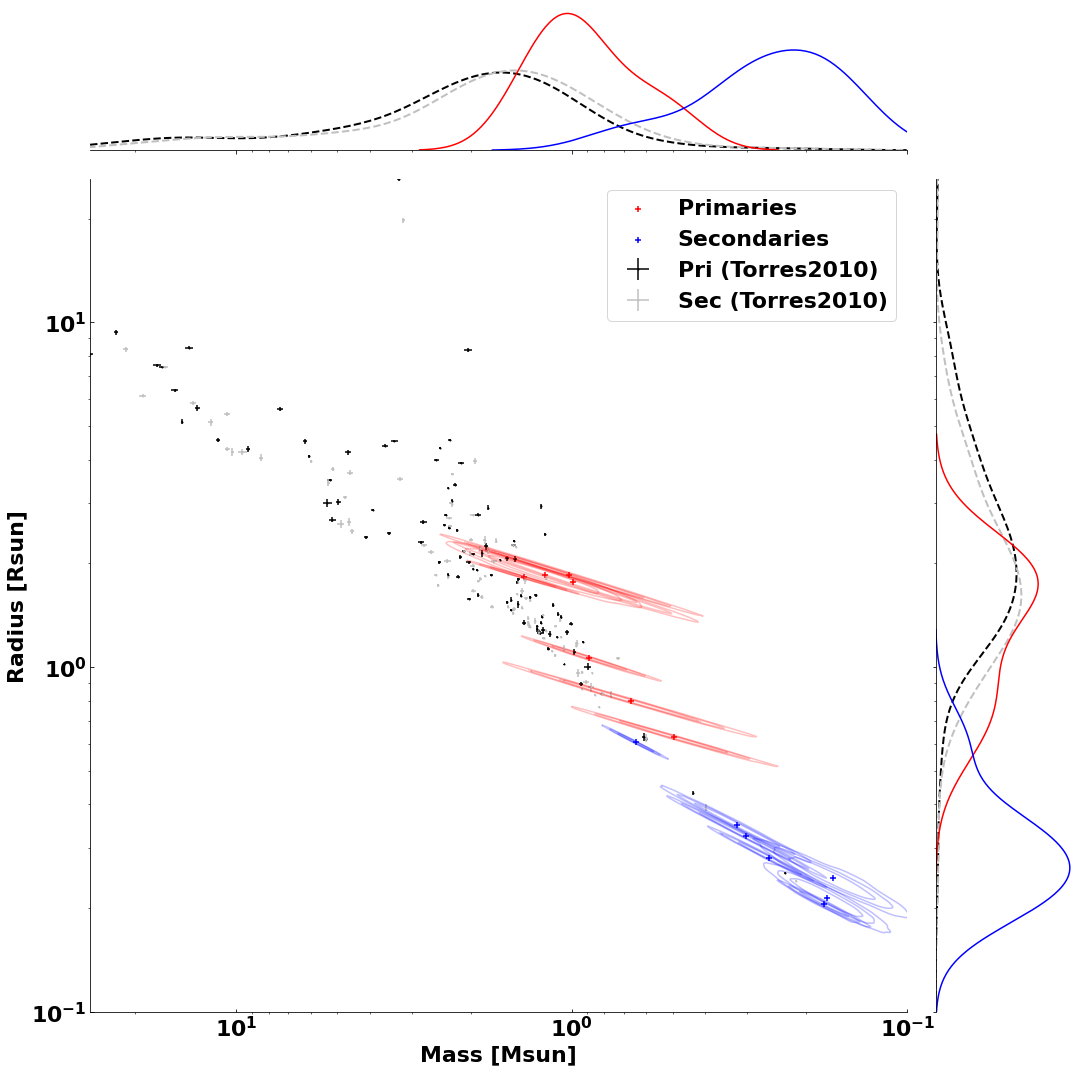

In [278]:
def plot_all_mass_radii_joint(TIC_LIST=None,Ntune=1000, Ndraw=500, chains=4,
                                model_type='1x', save_to_disk=False):
    import scipy.stats as st
    import seaborn as sns
    if TIC_LIST is None:
        TIC_LIST = [
                        28159019,
                        272074664,
                        20215452,
                        99254945,
#                         144441148,
                        169820068,
#                         126232983,
                        164458426,
                        164527723,
                        165453878,
                        258108067,
                        271548206,
                        365204192
                        ]

#     fig,axes = plt.subplots(figsize=(15,15))
#      ax = fig.add_subplot()
    ax = sns.jointplot(height=15)
    ax.ax_joint.tick_params(direction='in')
    #Table 1 from Willy Torres' review article on detached eclipsing binaries
    #https://ui.adsabs.harvard.edu/abs/2010A%26ARv..18...67T/abstract
    from astropy.table import Table
    tor = Table.read("https://cdsarc.cds.unistra.fr/ftp/J/other/A+ARV/18.67/table1.dat",
                 readme="https://cdsarc.cds.unistra.fr/ftp/J/other/A+ARV/18.67/ReadMe",
                 format="ascii.cds")
    
    mass = tor["Mass"]
    e_mass = tor["e_Mass"]
    radius = tor["Rad"]
    e_radius = tor["e_Rad"]
    maxR = max(radius)
    maxM = max(mass)
    pri = tor["Comp"] == 'A' #primaries
    sec = tor["Comp"] == 'B' #secondaries
    print(min(tor['Per']),max(tor['Per']))
    print(min(joined_t1_t3['Per']), max(joined_t1_t3['Per']))
    tor.info()
    priC,secC = 'black','silver'
    
    ax.ax_joint.set_xscale('log')
    ax.ax_joint.set_yscale('log')
    
    ax.ax_joint.errorbar(mass[pri], radius[pri], xerr=e_mass[pri], yerr=e_radius[pri], 
                fmt='o', ms=1,ecolor=priC,mec=priC,mfc=priC,label='Pri (Torres2010)',alpha=1.0,)
    ax.ax_joint.errorbar(mass[sec], radius[sec], xerr=e_mass[sec], yerr=e_radius[sec], 
                fmt='o', ms=1,ecolor=secC,mec=secC,mfc=secC,label='Sec (Torres2010)',alpha=1.0,)
#     sns.pointplot(x=mass[pri],y=radius[pri],color='black',alpha=0.25,ax=ax.ax_joint,join=False)
#     sns.pointplot(x=mass[sec],y=radius[sec],color='gray',alpha=0.25,ax=ax.ax_joint,join=False)
    sns.kdeplot(y=radius[pri], linewidth=2, ax=ax.ax_marg_y,color=priC,fill=False,ls='--')
    sns.kdeplot(x=mass[pri], linewidth=2, ax=ax.ax_marg_x,color=priC,fill=False,ls='--')

    sns.kdeplot(y=radius[sec], linewidth=2, ax=ax.ax_marg_y,color=secC,fill=False,ls='--')
    sns.kdeplot(x=mass[sec], linewidth=2, ax=ax.ax_marg_x,color=secC,fill=False,ls='--',)
    
#     ax.ax_joint.legend(loc='best',fontsize=16)
    ax.ax_joint.set_xlabel("Mass [Msun]",)
    ax.ax_joint.set_ylabel("Radius [Rsun]")
    ax.ax_joint.set_xlim(xmin=maxM,xmax=0.1)
    ax.ax_joint.set_ylim(ymin=0.1,ymax=maxR)


    
#     x1,x2 = ax.set_xlim()
#     print(x1,x2)
#     y1,y2 = ax.set_ylim()
    
    label_list = []
    pri_list = [[],[]]
    sec_list = [[],[]]
    system_params = {
        'tic':[],
        'period':[],
        'a':[],
        'incl':[],
        'omega':[],
        'ecc':[],
        'M1':[],
        'R1':[],
        'M2':[],
        'R2':[],
        't0':[],
        }
    for ticid in TIC_LIST:
        try:
            file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/TIC {ticid}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
            mv_res_dict = pk.load(file)
            file.close()
            flat_samps = mv_res_dict['trace'].posterior.stack(sample=('chain','draw'))
            if ticid == 20215452:
                print(flat_samps.to_dict()['data_vars'].keys())
#             print(fs_df.columns)
            m1 = flat_samps['M1'].values
            r1 = flat_samps['R1'].values
            m2 = (flat_samps['M2'].values)
            r2 = (flat_samps['R2'].values)
#             print(len(m1),len(r1),len(m2),len(r2))

            m1min,m1med,m1max = np.percentile(m1,[25,50, 75])
            r1min,r1med,r1max = np.percentile(r1,[25,50, 75])

            m2min,m2med,m2max = np.percentile(m2,[25,50, 75])
            r2min,r2med,r2max = np.percentile(r2,[25,50, 75])

            system_params['tic'].append(ticid)
            for col in list(system_params.keys())[1:]:
                system_params[col].append(flat_samps[col].median().values)
#             m1xx,r1yy = np.mgrid[m1min:m1max:100j, r1min:r1max:100j]
#             p_pos = np.vstack([m1xx.ravel(), r1yy.ravel()])
#             p_vals = np.vstack([m1,r1])
#             p_kern = st.gaussian_kde(p_vals)
#             p_f = np.reshape(p_kern(p_pos).T, m1xx.shape)


#             m2xx,r2yy = np.mgrid[m2min:m2max:100j, r2min:r2max:100j]
#             s_pos = np.vstack([m2xx.ravel(), r2yy.ravel()])
#             s_vals = np.vstack([m2,r2])
#             s_kern = st.gaussian_kde(s_vals)
#             s_f = np.reshape(s_kern(s_pos).T, m2xx.shape)


#             p_cset = ax.contour(m1xx,r1yy, p_f, colors='r',levels=2,alpha=0.25,zorder=-1)
            sns.kdeplot(x=m1,y=r1,fill=False,
                        levels=[0.1,0.25,0.5],color='r',alpha=0.25,ax=ax.ax_joint,log_scale=True)
    
#             ax.scatter(m1med,r1med,marker='+',color='r',s=50)
#             ax.text(x2+0.1*x2, r1med, f"TIC {ticid}",color='r',fontsize=8)
#             label_list.append(ax.text(m1med+1*m1med, r1med+0.1*r1med, f"TIC {ticid}",color='r',fontsize=8))
#             s_cset = ax.contour(m2xx,r2yy, s_f, colors='b',levels=2,alpha=0.25,zorder=-1)
            sns.kdeplot(x=m2,y=r2,fill=False,
                        levels=[0.1,0.25,0.5],color='b',alpha=0.25,ax=ax.ax_joint,log_scale=True)
#             ax.scatter(m2med,r2med,marker='+',color='b',s=50)
#             label_list.append(ax.text(m2med+1*m2med, r2med+0.1*r2med, f"TIC {ticid}",color='b',fontsize=8))

            pri_list[0].append(m1med)
            pri_list[1].append(r1med)
        
            sec_list[0].append(m2med)
            sec_list[1].append(r2med)

        except:
            continue
    ax.ax_joint.scatter(pri_list[0],pri_list[1],marker='+',c='r',label='Primaries')
    ax.ax_joint.scatter(sec_list[0],sec_list[1],marker='+',c='b',label='Secondaries')
    
    sns.kdeplot(x=pri_list[0],color='r',fill=False,ax=ax.ax_marg_x)
    sns.kdeplot(y=pri_list[1],color='r',fill=False,ax=ax.ax_marg_y)

    sns.kdeplot(x=sec_list[0],color='b',fill=False,ax=ax.ax_marg_x)
    sns.kdeplot(y=sec_list[1],color='b',fill=False,ax=ax.ax_marg_y)
#     adjust_text(label_list, arrowprops=dict(arrowstyle="-", color='gray', lw=1))
#     plt.show()
    ax.ax_joint.legend()

#     pd.DataFrame(system_params, columns=system_params.keys()).to_csv(DD+"system_params.csv")
    
    mod_str = f"Nc{chains}Nt{Ntune}Nd{Ndraw}"
    if save_to_disk:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/good_systems_{mod_str}_MR_contours_joint.png", bbox_inches='tight', dpi=150)
plot_all_mass_radii_joint(Ntune=1500, Ndraw=750, chains=6, model_type='8x',save_to_disk=True)

<Table length=44>
  name   dtype      unit                    description                    class     n_bad
------- ------- ------------ ------------------------------------------ ------------ -----
    Seq   int64                         [1/95] System sequential number       Column     0
 Name_1   str15           --                 Star name of the component MaskedColumn     0
    Per float64            d                    Period of the component       Column     0
  u_Per    str1                                 Uncertainty flag on Per MaskedColumn    44
  x_Per    str1                                [y] y if period in years MaskedColumn    43
   Comp    str1                                          [AB] Component       Column     0
 SpType    str8         ----          MK spectral type of the component       Column     0
   Mass float64         Msun                      Mass of the component       Column     0
 e_Mass float64         Msun                    rms uncertainty on Mass 

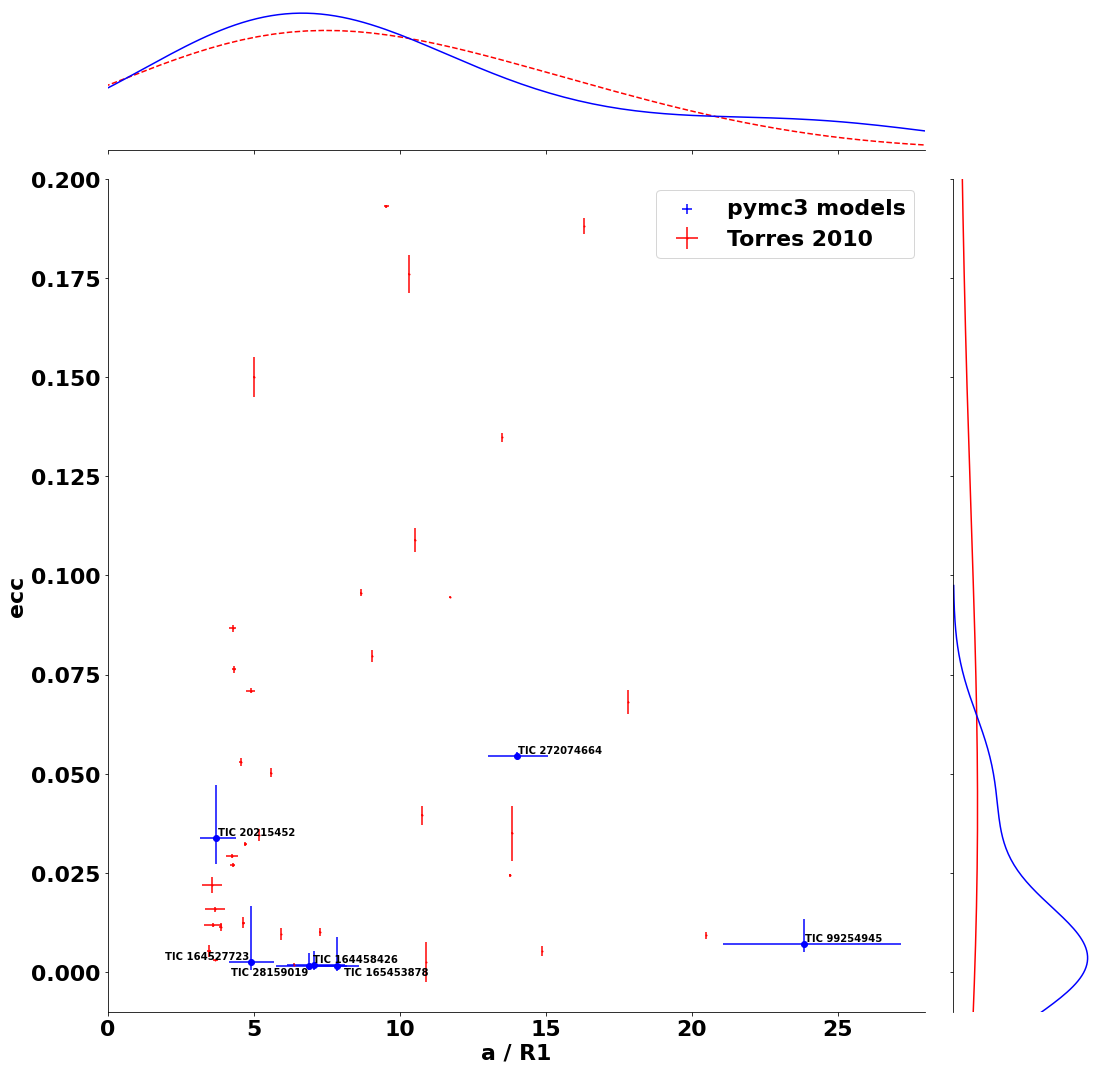

In [277]:
def plot_scaled_a_and_ecc_joint(TIC_LIST=None,Ntune=1000, Ndraw=500, chains=4,
                                model_type='1x', save_to_disk=False):
    import scipy.stats as st
    import seaborn as sns
    if TIC_LIST is None:
        TIC_LIST = [
                        28159019,
                        272074664,
                        20215452,
                        99254945,
#                         144441148,
                        169820068,
#                         126232983,
                        164458426,
                        164527723,
                        165453878,
                        258108067,
                        271548206,
                        365204192
                        ]
    
#     fig,axes = plt.subplots(figsize=(15,15))
#      ax = fig.add_subplot()
    ax = sns.jointplot(height=15)
    #Table 1 from Willy Torres' review article on detached eclipsing binaries
    #https://ui.adsabs.harvard.edu/abs/2010A%26ARv..18...67T/abstract
    from astropy.table import Table
    tor_orig = Table.read("https://cdsarc.cds.unistra.fr/ftp/J/other/A+ARV/18.67/table1.dat",
                 readme="https://cdsarc.cds.unistra.fr/ftp/J/other/A+ARV/18.67/ReadMe",
                 format="ascii.cds")
    
    tor = joined_t1_t3#astab.unique(joined_t1_t3, keys='Seq')
    print(tor.info())
    mass = tor["Mass"]
    e_mass = tor["e_Mass"]
    radius = tor["Rad"]
    e_radius = tor["e_Rad"]
    maxR = max(radius)
    maxM = max(mass)
    pri = tor["Comp"] == 'A' #primaries
    sec = tor["Comp"] == 'B' #secondaries
    priC,secC = 'red','silver'
    
    all_semi_a = spit_out_circorbit_a(only_pri['mtot'],only_pri['Per']).to(u.Rsun).value
    all_scaled_a = all_semi_a / only_pri['Rad'].to(u.Rsun).value
    
    semi_a = spit_out_circorbit_a(tor['mtot'],tor['Per']).to(u.Rsun).value
    scaled_a = semi_a / tor['Rad'].to(u.Rsun).value
    
#     ax.ax_joint.set_xscale('log')
#     ax.ax_joint.set_yscale('log')
    
    ax.ax_joint.errorbar(scaled_a, tor['Ecc'], xerr=tor['e_Mass'], yerr=tor['e_Ecc'], 
                fmt='o', ms=1,ecolor=priC,mec=priC,mfc=priC,label='Torres 2010',alpha=1.0,)
    
    sns.kdeplot(x=scaled_a,ax=ax.ax_marg_x,ls='--',color='red')
#     sns.kdeplot(x=all_scaled_a,ax=ax.ax_marg_x,ls='-',color='black')
    
    sns.kdeplot(y=tor['Ecc'],ax=ax.ax_marg_y,ls='-',color='red')

    ax.ax_joint.set_ylabel("ecc")
    ax.ax_joint.set_xlabel("a / R1")
    ax.ax_joint.set_xlim(0,28)
    ax.ax_joint.set_ylim(-.01,0.2)
#     ax.ax_joint.set_ylim(ymin=0.1,ymax=maxR)


    
#     x1,x2 = ax.set_xlim()
#     print(x1,x2)
#     y1,y2 = ax.set_ylim()
    
    label_list = []
    xvals,yvals = [],[]
    system_params = {
        'tic':[],
        'period':[],
        'a':[],
        'incl':[],
        'omega':[],
        'ecc':[],
        'M1':[],
        'R1':[],
        'M2':[],
        'R2':[],
        't0':[],
        }
    for ticid in TIC_LIST:
        try:
            file = open(f"/Users/kjaehnig/CCA_work/GAT/pymc3_models/TIC {ticid}_pymc3_Nt{Ntune}_Nd{Ndraw}_Nc{chains}_individual_priors_{model_type}_isochrones.pickle",'rb')
            mv_res_dict = pk.load(file)
            file.close()
            flat_samps = mv_res_dict['trace'].posterior.stack(sample=('chain','draw'))
            if ticid == 20215452:
                print(flat_samps.to_dict()['data_vars'].keys())
#             print(fs_df.columns)
            m1 = flat_samps['M1'].values
            r1 = flat_samps['R1'].values
            m2 = (flat_samps['M2'].values)
            r2 = (flat_samps['R2'].values)
#             print(len(m1),len(r1),len(m2),len(r2))

            ecc = flat_samps['ecc'].values
            a = flat_samps['a'].values * u.Rsun
            r1 = flat_samps['R1'].values * u.Rsun
        
#             scaled_a = (a/r1).decompose()
#             print((a/r1).unit)
            amin,amed,amax = np.percentile(a,[16,50,84])
            r1min,r1med,r1max = np.percentile(r1,[16,50,84])
        
            xmed = (amed/r1med).decompose().value
            xmin = xmed * np.sqrt(((r1med-r1min)/r1med)**2. + ((amed-amin)/amed)**2.).decompose().value
            xmax = xmed * np.sqrt(((r1max-r1med)/r1med)**2. + ((amax-amed)/amed)**2.).decompose().value


#             xmin,xmed,xmax = np.percentile(scaled_a,[25,50, 75])
            ymin,ymed,ymax = np.percentile(ecc,[16,50, 84])
#             print(m1min,m1med,m1max)

            ax.ax_joint.errorbar(xmed,ymed, xerr=[[xmin], [xmax]],
                                    yerr=[[ymed-ymin], [ymax-ymin]],
                                    fmt='o',ecolor='blue',mec='blue',mfc='blue')

            xvals.append(xmed)
            yvals.append(ymed)
#             plt.gcf().text(0.02, 1., f"TIC {ticid}", fontsize=10)
            label_list.append(ax.ax_joint.text(xmed,ymed,
                    f"TIC {ticid}",fontsize=10,
                    horizontalalignment='left',
                    verticalalignment='bottom'))


        except:
            continue
            
    sns.kdeplot(x=xvals,color='b',fill=False,ax=ax.ax_marg_x)
    sns.kdeplot(y=yvals,color='b',fill=False,ax=ax.ax_marg_y)
    ax.ax_joint.scatter(xvals,np.array(yvals)+100,s=100,marker='+',ec='blue',fc='blue',label='pymc3 models')
    ax.ax_joint.legend(loc='upper right')
    adjust_text(label_list, ax=ax.ax_joint)
    
    
    mod_str = f"Nc{chains}Nt{Ntune}Nd{Ndraw}"
    if save_to_disk:
        plt.savefig(f"/Users/kjaehnig/CCA_work/GAT/good_systems_{mod_str}_scaled_a_ecc_joint.png", bbox_inches='tight', dpi=150)

plot_scaled_a_and_ecc_joint(Ntune=1500, Ndraw=750, chains=6, model_type='8x',save_to_disk=True)

In [294]:
def foldable_histogram(Nbins=100, period=None, t0=None, lks=None): 
    Nbins = 100  # int(len(lks.time.value) / 1000.)
    bins = np.linspace(-0.5*period, 0.5*period, Nbins)
    x_ = hf.fold(lks.time.value, period, t0)
    y_ = lks.flux.value
    num, _ = np.histogram(x_, bins, weights=y_)
    denom, _ = np.histogram(x_, bins)
    num[denom > 0] /= denom[denom > 0]
    num[denom == 0] = np.nan
    return (bins, num)


good_tics = ["20215452", 
             "272074664", 
             "99254945", 
             "28159019", 
             "164527723", 
             "164458426", 
             "165453878"]

def make_folded_lightcurve_from_blsres(TIC_LIST=None,Ntune=1000, Ndraw=500, chains=8,
                                model_type='1x', save_to_disk=False):
    import scipy.stats as st
    import seaborn as sns
    if TIC_LIST is None:
        TIC_LIST = [
                        28159019,
                        272074664,
                        20215452,
                        99254945,
                        144441148,
                        169820068,
                        126232983,
                        164458426,
                        164527723,
                        165453878,
                        258108067,
                        271548206,
                        365204192
                        ]
    

    bls_period = 3#blsres['period_at_max_power'].value
#     bls_t0 = blsres['t0_at_max_power'].value
        
    rcParams['font.size'] = 8
    rcParams['font.weight'] = 'heavy'
    rcParams['axes.labelweight'] = rcParams['font.weight']
    rcParams['axes.labelsize'] = rcParams['font.size']

    fig,axes = plt.subplots(figsize=(18, 9), nrows=2, ncols=7)
    axes[1,-1].remove()
    axes[1,0].remove()
    
    [ii.yaxis.set_major_formatter(FormatStrFormatter('%.2f')) for ii in axes.flat]
    [ii.xaxis.set_major_formatter(FormatStrFormatter('%.1f')) for ii in axes.flat]
    
    [ii.set_xlabel('phase (d)') for ii in axes.flatten()[-7:]]
    [ii.set_ylabel('flux') for ii in axes[:,0]]
    for ticid,ax in zip(TIC_LIST, axes.flat):
        try:
            file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/TIC_{ticid}_highres_bls_params.pickle",'rb')
            blsres = pk.load(file)
            file.close()

            file = open(f"/Users/kjaehnig/CCA_work/GAT/joker_TESS_lightcurve_files/TIC_{ticid}_lightcurve_data.pickle","rb")
            res = pk.load(file)
            file.close()

                #     print(calibverr.info)
            # Grab cross-match IDs
            ## joining calib RV_ERRs with the RVs
        
            lks = res['lk_coll'].stitch(corrector_func=lambda x: x.remove_nans().normalize())


            bls_period = blsres['period_at_max_power'].value
            bls_t0 = blsres['t0_at_max_power'].value
            
            bins, num = foldable_histogram(100, bls_period, bls_t0, lks)
#             ax.scatter(hf.fold(lks.time.value, bls_period, bls_t0), 
#                 lks.flux.value, marker='o',s=0.5,
#                 c=lks.time.value - lks.time.min().value,
#                 cmap=cm.inferno #fold(lks.time.value, bls_period, bls_t0)
#                 )

            x_fold = hf.fold(lks.time.value, bls_period, bls_t0)
            inds = np.argsort(x_fold)
            ax.set_title(f"TIC {ticid}", fontweight='heavy')
            ax.tick_params(direction='in')
            ax.scatter(x_fold[inds], lks.flux.value[inds], c=lks.time.value[inds],
                      cmap='inferno', s=10)
            ax.plot(0.5 * (bins[1:] + bins[:-1]), num, color='white', lw=4,zorder=10)
            ax.plot(0.5 * (bins[1:] + bins[:-1]), num, color='cyan', lw=2,zorder=11)
            
            xl1,xl2 = ax.set_xlim()
            yl1,yl2 = ax.set_ylim()
            
#             if str(ticid) not in good_tics:
#                 ax.plot([0, 1], [0, 1], transform=ax.transAxes, lw=20, c='red', zorder=999)
#                 ax.plot([0, 1], [1,0], transform=ax.transAxes, lw=20, c='red', zorder=999)
        except:
            continue

    if save_to_disk:
        plt.savefig(DD + "lk_multiplot_13_final_systems.jpg",dpi=150, bbox_inches='tight')
            
#     ax[1,0].set_ylim(lks.flux.min(), lks.flux.max())
    
    
#     fig.colorbar(lc_folded_)
#     ax.set_xlim(-1,1)

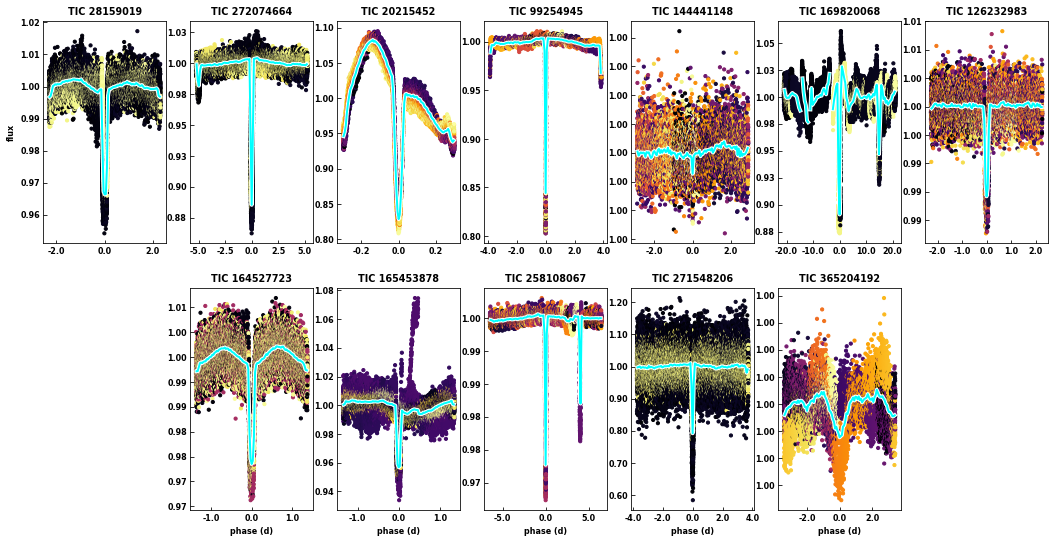

In [295]:
make_folded_lightcurve_from_blsres(save_to_disk=True)